<a href="https://colab.research.google.com/github/cs-iuu/word-sense-2025-fall-ai/blob/main/notebooks/15.2.wsi_niv_cht_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 2: Preprocessing: Extract Common Nouns

In [ ]:
!pip install spacy jieba pandas --break-system-packages
!python -m spacy download en_core_web_sm
import nltk
nltk.download('wordnet')

In [ ]:
!pip install torch transformers numpy pandas --break-system-packages

In [ ]:
!pip install scikit-learn numpy pandas --break-system-packages

In [ ]:
!pip install nltk scipy matplotlib seaborn pandas numpy --break-system-packages

In [ ]:
!pip install hdbscan

In [ ]:
"""
Step 2: Preprocessing
======================
Tokenizes, POS-tags, and lemmatizes both corpora.
Extracts common nouns only (no proper nouns, pronouns, or stopwords).
Applies a minimum frequency threshold to filter rare words.

Outputs:
  - data/english_nouns.csv   : lemma, verse_id, token, context (full verse)
  - data/chinese_nouns.csv   : lemma, verse_id, token, context
  - data/english_noun_freq.csv
  - data/chinese_noun_freq.csv

Usage:
  pip install spacy jieba pandas --break-system-packages
  python -m spacy download en_core_web_sm
  python 02_preprocessing.py

Design decisions (paper §3.2):
  - English: spaCy en_core_web_sm for tokenization, POS, lemmatization
  - Chinese: jieba for word segmentation + custom POS (jieba.posseg)
  - POS filters: English NOUN tag; Chinese POS prefix 'n' (common noun)
  - Proper noun exclusion: English PROPN tag excluded; Chinese 'nr','ns','nt','nz' excluded
  - Minimum frequency: MIN_FREQ = 30 (ensures sufficient WSI context)
  - Stopwords: NLTK English stopwords; custom Chinese stopword list
"""

import re
import pandas as pd
from pathlib import Path
from collections import Counter

# ─── Configuration ────────────────────────────────────────────────────────────

DATA_DIR = Path("/content") / "bible_data"
MIN_FREQ = 30          # Minimum occurrences per lemma for WSI
MAX_CONTEXT_LEN = 512  # Characters — prevents overlong inputs to transformers

# Chinese POS tags for common nouns (jieba.posseg notation)
ZH_NOUN_PREFIXES = {"n"}           # Common noun prefix
ZH_EXCLUDE_TAGS  = {"nr", "ns", "nt", "nz", "nw"}  # Proper nouns to exclude

# ── Theological proper noun exclusion lists ───────────────────────────────────
# These terms are proper nouns in English (God, Lord, Christ etc.) — excluded
# by spaCy's PROPN tag — but are tagged as common nouns n by jieba in Chinese
# due to the absence of capitalisation. They must be excluded explicitly from
# the Chinese data to ensure cross-lingual comparability.
#
# English side: spaCy correctly tags God/Lord/Christ as PROPN (excluded).
# Exception: "Spirit" (Holy Spirit) is sometimes tagged NOUN by spaCy, so it
# is added to EN_THEOLOGICAL_EXCLUDE as a lemma-level backstop.
#
# Borderline cases kept in both languages:
#   先知/prophet  — generic occupational noun, polysemous, common in both
#   天使/angel    — generic supernatural being, common noun in both
#   魔鬼/devil    — common noun in EN; jieba tags n in ZH

ZH_THEOLOGICAL_EXCLUDE = {
    # Core deity names / titles
    "神",     # God (most frequent — 1244 occurrences)
    "主",     # Lord
    "上帝",   # God (formal)
    "耶和華", # Yahweh / LORD
    "基督",   # Christ
    "耶穌",   # Jesus (also usually tagged nr, but belt-and-suspenders)
    "聖靈",   # Holy Spirit
    "聖神",   # Holy Spirit (alternate form in some CUV editions)
    "彌賽亞", # Messiah
    # Adversarial proper nouns
    "撒但",   # Satan
    "別西卜", # Beelzebub
}

EN_THEOLOGICAL_EXCLUDE = {
    # Lemma-level backstop for cases where spaCy tags as NOUN not PROPN
    "spirit",    # "Holy Spirit" — spaCy inconsistently tags as NOUN
    "ghost",     # "Holy Ghost" (KJV form; rare in NIV but present)
}

# KJV-specific: exclude archaic pronouns/verbs mis-tagged as nouns
KJV_ARCHAIC_EXCLUDE = {
    # Archaic pronouns
    "thou",       # 1853
    "ye",         # 1382
    "thee",       # 926
    "thine",      # 645
    "thy",        # 1

    # Archaic verbs
    "shalt",      # 1582
    "hath",       # 497
    "art",        # 482
    "hast",       # 377
    "wilt",       # 204
    "begat",      # 161
    "goeth",      # 78
    "doth",       # 67
    "endureth",   # 58
    "cometh",     # 55
    "mayest",     # 55
    "dwelleth",   # 47
    "liveth",     # 43
    "didst",      # 39
    "remaineth",  # 32
    "walketh",    # 29
    "goest",      # 28
    "passeth",    # 28
    "knoweth",    # 27
    "speaketh",   # 22
    "saidst",     # 20
    "saith",      # 20
    "eateth",     # 19
    "belongeth",  # 17
    "beareth",    # 15
    "turneth",    # 15
    "bringeth",   # 14
    "reacheth",   # 13
    "seemeth",    # 13
    "putteth",    # 13
    "burneth",    # 12
    "spreadeth",  # 12
    "calleth",    # 12
    "mourneth",   # 11
    "sweareth",   # 10
    "doest",      # 10
    "committeth", # 10
    "sitteth",    # 10
    "seeth",      # 10
    "crieth",     # 10
    "seeketh",    # 9
    "toucheth",   # 9
    "perisheth",  # 9
    "seeketh",    # 9
    "groweth",    # 9
    "reigneth",   # 9
    "dieth",      # 9
    "appeareth",  # 9
    "waiteth",    # 9
    "abideth",    # 8
    "judgeth",    # 8
    "languisheth",# 8
    "delighteth", # 8
    "faileth",    # 8
    "causeth",    # 8
    "standeth",   # 7
    "spake",      # 7
    "runneth",    # 7
    "aileth",     # 7
    "withereth",  # 6
    "falleth",    # 6
    "looketh",    # 6
    "hideth",     # 6
    "keepeth",    # 6
    "soweth",     # 6
    "desireth",   # 6
    "fleeth",     # 6
    "understandeth",# 6
    "trustest",   # 6
    "treadeth",   # 5
    "reproacheth",# 5
    "delivereth", # 5
    "commandeth", # 5
    "pertaineth", # 5
    "shineth",    # 5
    "taketh",     # 5
    "fadeth",     # 5
    "ariseth",    # 5
    "answereth",  # 4
    "availeth",   # 4
    "escapeth",   # 4
    "trusteth",   # 4
    "travaileth", # 4
    "troubleth",  # 4
    "melteth",    # 4
    "proceedeth", # 4
    "maketh",     # 4
    "destroyeth", # 4
    "devoureth",  # 4
    "riseth",     # 4
    "heareth",    # 4
    "sheweth",    # 4
    "sinneth",    # 4
    "followeth",  # 4
    "moveth",     # 4
    "longeth",    # 4
    "pisseth",    # 3
    "trustedst",  # 3
    "stirreth",   # 3
    "stoodest",   # 3
    "careth",     # 3
    "hatest",     # 3
    "roareth",    # 3
    "sacrificeth",# 3
    "ruleth",     # 3
    "dealeth",    # 3
    "decayeth",   # 3
    "serveth",    # 3
    "calledst",   # 3
    "teacheth",   # 3
    "rewardeth",  # 3
    "deliveredst",# 3
    "meaneth",    # 3
    "gathereth",  # 3
    "strengtheneth",# 3
    "camest",     # 3
    "breaketh",   # 3
    "bewrayeth",  # 3
    "dwellest",   # 3
    "offereth",   # 3
    "mocketh",    # 3
    "spakest",    # 3
    "sojourneth", # 3
    "increaseth", # 2
    "withholdeth",# 2
    "witnesseth", # 2
    "baptizeth",  # 2
    "fighteth",   # 2
    "blesseth",   # 2
    "trieth",     # 2
    "trembleth",  # 2
    "kindleth",   # 2
    "boasteth",   # 2
    ## skipped
    "shouldest",  # 1
    "wouldest",   # 0
    "couldest",   # 0

    # Other archaic words
    "nigh",       # 81
}

# Path to custom jieba dictionary for biblical proper names
JIEBA_DICT_PATH = Path("/content") / "bible_data" / "jieba_biblical_dict.txt"

# ── Post-segmentation POS correction ─────────────────────────────────────────
# jieba's POS tagger runs independently of the segmentation dictionary and
# can assign incorrect tags even for dictionary entries. These words are
# forced to tag n after segmentation regardless of what the POS tagger assigned.
#
# 地: jieba assigns uv (虛詞/copular particle) in classical subject-predicate
#     constructions like 地是空虛混沌 (Gen.1.2) because it parses 地 as a
#     topic marker rather than a subject noun. This is a known jieba limitation
#     with literary Chinese. Since English "earth" (freq=739) is always tagged
#     NOUN by spaCy, forcing 地 to n is required for cross-lingual comparability.
ZH_FORCE_NOUN_TAG = {
    "地",   # earth/ground/land — incorrectly tagged uv in copular constructions
}

# ─── English Preprocessing ────────────────────────────────────────────────────


def preprocess_english(verse_csv: Path) -> pd.DataFrame:
    """
    Process English verses with spaCy.
    Returns long-format DataFrame: one row per noun occurrence.
    """
    try:
        import spacy
    except ImportError:
        raise ImportError("Run: pip install spacy --break-system-packages && python -m spacy download en_core_web_sm")

    print("  [EN] Loading spaCy model…")
    nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])

    df = pd.read_csv(verse_csv)
    print(f"  [EN] Processing {len(df):,} verses…")

    import time
    records   = []
    texts     = df["text"].tolist()
    verse_ids = df["verse_id"].tolist()
    total     = len(texts)
    t0        = time.time()

    for i, (doc, vid) in enumerate(zip(nlp.pipe(texts, batch_size=512), verse_ids), 1):
        context = doc.text[:MAX_CONTEXT_LEN]
        for token in doc:
            # Keep only common nouns; exclude proper nouns and pronouns
            if (
                token.pos_ == "NOUN"
                and not token.is_stop
                and not token.is_punct
                and len(token.lemma_) > 1
                and token.lemma_.isalpha()
                and token.lemma_.lower() not in EN_THEOLOGICAL_EXCLUDE
                ## for KJV processing-only
                and token.lemma_.lower() not in KJV_ARCHAIC_EXCLUDE
            ):
                records.append({
                    "verse_id": vid,
                    "token":    token.text,
                    "lemma":    token.lemma_.lower(),
                    "context":  context,
                })
        if i % 1000 == 0 or i == total:
            elapsed = time.time() - t0
            rate    = i / elapsed if elapsed > 0 else 0
            eta_min = (total - i) / rate / 60 if rate > 0 else 0
            print(f"    … {i:,}/{total:,} verses  "
                  f"({rate:.0f} v/s)  "
                  f"ETA {eta_min:.1f} min  "
                  f"nouns so far: {len(records):,}",
                  end="\r")

    elapsed_total = time.time() - t0
    print(f"\n  [EN] Done in {elapsed_total/60:.1f} min. "
          f"Extracted {len(records):,} noun occurrences.")
    return pd.DataFrame(records)


# ─── Chinese Preprocessing ────────────────────────────────────────────────────


def preprocess_chinese(verse_csv: Path) -> pd.DataFrame:
    """
    Process Chinese verses with jieba (word segmentation + POS tagging).
    Returns long-format DataFrame: one row per noun occurrence.
    """
    import time
    try:
        import jieba
        import jieba.posseg as pseg
    except ImportError:
        raise ImportError("Run: pip install jieba --break-system-packages")

    # Silence jieba logging FIRST, before any other jieba calls
    jieba.setLogLevel("ERROR")

    # Load custom dictionary
    if JIEBA_DICT_PATH.exists():
        jieba.load_userdict(str(JIEBA_DICT_PATH))
        print(f"  [ZH] Loaded custom dictionary: {JIEBA_DICT_PATH.name}", flush=True)
    else:
        print(f"  [ZH] WARNING: custom dictionary not found at {JIEBA_DICT_PATH}", flush=True)

    # Force jieba to build its internal trie NOW with a visible message.
    # Without this explicit call, the first pseg.cut() silently blocks
    # for 30-60 seconds before any progress lines appear.
    print("  [ZH] Building jieba model (one-time, ~10-30s)...", flush=True)
    jieba.initialize()
    print("  [ZH] Model ready.", flush=True)

    zh_stopwords = _load_chinese_stopwords()

    df    = pd.read_csv(verse_csv)
    total = len(df)
    print(f"  [ZH] Processing {total:,} verses...", flush=True)
    t0 = time.time()

    records = []
    for i, row in enumerate(df.itertuples(index=False), 1):
        verse_id = row.verse_id
        text     = str(row.text)
        context  = text[:MAX_CONTEXT_LEN]

        for word, flag in pseg.cut(text):
            flag_str = str(flag)
            # Force known mis-tagged tokens to correct POS
            if word in ZH_FORCE_NOUN_TAG:
                flag_str = "n"
            if (
                flag_str[:1] in ZH_NOUN_PREFIXES
                and flag_str not in ZH_EXCLUDE_TAGS
                and word not in zh_stopwords
                and word not in ZH_THEOLOGICAL_EXCLUDE
                and len(word) >= 1
                and not word.isdigit()
            ):
                records.append({
                    "verse_id": verse_id,
                    "token":    word,
                    "lemma":    word,
                    "context":  context,
                })

        # Progress every 100 verses — print on new lines so nothing is missed
        if i % 100 == 0 or i == total:
            elapsed = time.time() - t0
            rate    = i / elapsed if elapsed > 0 else 0
            eta_min = (total - i) / rate / 60 if rate > 0 else 0
            print(
                f"    ... {i:,}/{total:,} verses"
                f"  ({rate:.0f} v/s)"
                f"  ETA {eta_min:.1f} min"
                f"  nouns: {len(records):,}",
                flush=True
            )

    elapsed_total = time.time() - t0
    print(f"  [ZH] Done in {elapsed_total/60:.1f} min. "
          f"Extracted {len(records):,} noun occurrences.")
    return pd.DataFrame(records)

def _load_chinese_stopwords() -> set:
    """
    Chinese function word stoplist for CUV Traditional (CHT) text.

    Design decisions:
    ─────────────────────────────────────────────────────────────
    1. CHT variants included alongside CHS equivalents for all
       characters that differ between scripts (說/说, 會/会, etc.)

    2. 人 is NOT a stopword. It is a genuine common noun meaning
       "person / people / man / humanity" and is highly polysemous
       in biblical text. Jieba tags it as n (common noun) in most
       contexts, so it passes the POS filter correctly. Removing it
       would discard one of the most semantically rich words in the
       corpus.

    3. Pronouns (他/她/祂/你/我 etc.) are NOT listed here. They are
       tagged by jieba as r (pronoun), which is already excluded by
       the POS filter (we keep only n* tags). Listing them would be
       redundant. The various gendered and honorific variants
       (他/她/它/祂) all carry the r tag and are excluded uniformly.

    4. This list covers only high-frequency grammatical function
       words that jieba may occasionally mis-tag as nouns.
       It is intentionally conservative.
    ─────────────────────────────────────────────────────────────
    """
    return {
        # Structural particles (occasionally mis-tagged as n by jieba)
        # NOTE: 地 is intentionally NOT listed here.
        # In CUV literary style, 地 is overwhelmingly used as a noun
        # (earth/land/ground) matching English "earth" (freq=739).
        # The adverbial particle use of 地 is rare in classical biblical text.
        # Removing it would create an asymmetry with English where "earth"
        # is correctly retained as a high-frequency common noun.
        "的", "得",
        # Aspect markers — CHT: 著, CHS: 着
        "了", "著", "着",
        # Conjunctions / connectives
        "和", "與", "与", "及", "或", "但", "而", "且",
        # Adverbs sometimes mis-tagged
        "也", "都", "就", "才", "又", "還", "还", "已",
        "很", "更", "最", "太", "非常",
        # Negation
        "不", "沒有", "没有", "未", "無", "无",
        # Existential / copular
        "是", "有", "在",
        # Determiners / quantifiers
        "一", "這", "这", "那", "各", "每", "某", "其",
        # Directional / locative words with no sense variation
        "上", "下", "中", "內", "内", "外", "前", "後", "后",
        "裡", "里", "間", "间",
        # Common verbs jieba occasionally tags as nouns in CUV
        "說", "说", "看", "去", "來", "来", "到", "給", "给",
        "要", "會", "会",
    }


# ─── Frequency Filtering ──────────────────────────────────────────────────────


def apply_frequency_filter(df: pd.DataFrame, min_freq: int = MIN_FREQ) -> tuple:
    """
    Keep only lemmas appearing at least `min_freq` times.
    Returns (filtered_df, freq_df).
    """
    freq = df.groupby("lemma").size().reset_index(name="count")
    freq = freq.sort_values("count", ascending=False)
    valid_lemmas = set(freq[freq["count"] >= min_freq]["lemma"])
    filtered = df[df["lemma"].isin(valid_lemmas)].copy()
    return filtered, freq

In [ ]:
print("=" * 60)
print("Step 2: Preprocessing")
print("=" * 60)

# ── English ───────────────────────────────────────────────────
# en_raw = preprocess_english(DATA_DIR / "english_verses.csv")
# en_filtered, en_freq = apply_frequency_filter(en_raw)
# en_filtered.to_csv(DATA_DIR / "english_nouns.csv", index=False, encoding="utf-8")
# en_freq.to_csv(DATA_DIR / "english_noun_freq.csv", index=False, encoding="utf-8")
# print(f"  [EN] {en_filtered['lemma'].nunique():,} lemmas ≥ {MIN_FREQ} occurrences retained.")

# ── Chinese ───────────────────────────────────────────────────
zh_raw = preprocess_chinese(DATA_DIR / "chinese_verses.csv")
zh_filtered, zh_freq = apply_frequency_filter(zh_raw)
zh_filtered.to_csv(DATA_DIR / "chinese_nouns.csv", index=False, encoding="utf-8")
zh_freq.to_csv(DATA_DIR / "chinese_noun_freq.csv", index=False, encoding="utf-8")
print(f"  [ZH] {zh_filtered['lemma'].nunique():,} lemmas ≥ {MIN_FREQ} occurrences retained.")

# ── Summary ───────────────────────────────────────────────────
print("\n── Preprocessing Summary ──")
# print(f"  EN noun tokens (filtered) : {len(en_filtered):,}")
# print(f"  EN unique lemmas          : {en_filtered['lemma'].nunique():,}")
print(f"  ZH noun tokens (filtered) : {len(zh_filtered):,}")
print(f"  ZH unique lemmas          : {zh_filtered['lemma'].nunique():,}")

# print("\n  Top 10 English nouns:")
# print(en_freq.head(10).to_string(index=False))
print("\n  Top 10 Chinese nouns:")
print(zh_freq.head(10).to_string(index=False))

print("\n✓ Step 2 complete.\n")

Step 2: Preprocessing
  [ZH] WARNING: custom dictionary not found at /content/bible_data/jieba_biblical_dict.txt
  [ZH] Building jieba model (one-time, ~10-30s)...
  [ZH] Model ready.
  [ZH] Processing 31,027 verses...
    ... 100/31,027 verses  (41 v/s)  ETA 12.5 min  nouns: 359
    ... 200/31,027 verses  (46 v/s)  ETA 11.2 min  nouns: 652
    ... 300/31,027 verses  (49 v/s)  ETA 10.5 min  nouns: 937
    ... 400/31,027 verses  (45 v/s)  ETA 11.4 min  nouns: 1,241
    ... 500/31,027 verses  (41 v/s)  ETA 12.3 min  nouns: 1,550
    ... 600/31,027 verses  (42 v/s)  ETA 12.0 min  nouns: 1,862
    ... 700/31,027 verses  (42 v/s)  ETA 12.0 min  nouns: 2,221
    ... 800/31,027 verses  (43 v/s)  ETA 11.8 min  nouns: 2,524
    ... 900/31,027 verses  (43 v/s)  ETA 11.6 min  nouns: 2,858
    ... 1,000/31,027 verses  (44 v/s)  ETA 11.5 min  nouns: 3,167
    ... 1,100/31,027 verses  (44 v/s)  ETA 11.3 min  nouns: 3,496
    ... 1,200/31,027 verses  (44 v/s)  ETA 11.4 min  nouns: 3,808
    ... 1,300

KeyboardInterrupt: 

# Step 3: Extract Context Embeddings

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from typing import List, Tuple

# ─── Configuration ────────────────────────────────────────────────────────────

DATA_DIR    = Path("/content") / "bible_data"
MODEL_NAME  = "xlm-roberta-base"   # Multilingual; same model for EN and ZH
BATCH_SIZE  = 32                   # Reduce to 8-16 if OOM on CPU
LAYERS      = [-1, -2, -3, -4]     # Last 4 layers averaged (standard WSI practice)
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SEQ_LEN = 128                  # Max subword tokens per sentence

print(f"Using device: {DEVICE}")

# ─── Model Loading ────────────────────────────────────────────────────────────

def load_model():
    print(f"  [model] Loading {MODEL_NAME}…")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model     = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
    model.to(DEVICE)
    model.eval()
    return tokenizer, model


# ─── Embedding Extraction ─────────────────────────────────────────────────────

def get_target_embedding(
    tokenizer,
    model,
    sentences:  List[str],
    target_words: List[str],
) -> np.ndarray:
    """
    For each (sentence, target_word) pair, extract the contextual embedding
    of the target by:
      1. Tokenizing the sentence
      2. Finding subword token positions for the target word
      3. Averaging hidden states across the last 4 layers at those positions
      4. Mean-pooling across subwords for multi-token targets

    Returns: np.ndarray of shape (N, hidden_dim)
    """
    all_embeddings = []

    for i in range(0, len(sentences), BATCH_SIZE):
        batch_sents  = sentences[i : i + BATCH_SIZE]
        batch_targets = target_words[i : i + BATCH_SIZE]

        encoded = tokenizer(
            batch_sents,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_SEQ_LEN,
            return_offsets_mapping=True,
        )
        offset_mappings = encoded.pop("offset_mapping")  # not passed to model

        encoded = {k: v.to(DEVICE) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)

        # Stack selected hidden layers: shape (n_layers, batch, seq_len, hidden)
        hidden_states = torch.stack(
            [outputs.hidden_states[l] for l in LAYERS], dim=0
        )
        # Mean over selected layers: (batch, seq_len, hidden)
        layer_mean = hidden_states.mean(dim=0).cpu().numpy()

        input_ids = encoded["input_ids"].cpu().numpy()

        for j, (target, offsets_j) in enumerate(zip(batch_targets, offset_mappings)):
            # Re-encode the target word alone to find its subword tokens
            target_enc = tokenizer.encode(
                target, add_special_tokens=False
            )
            # Find target subword positions in the sentence encoding
            target_positions = _find_subword_positions(
                input_ids[j].tolist(), target_enc
            )
            if target_positions:
                token_emb = layer_mean[j][target_positions].mean(axis=0)
            else:
                # Fallback: mean-pool entire sequence (excluding [CLS]/[SEP])
                seq_len = (input_ids[j] != tokenizer.pad_token_id).sum()
                token_emb = layer_mean[j][1 : seq_len - 1].mean(axis=0)

            all_embeddings.append(token_emb)

        if (i // BATCH_SIZE) % 10 == 0:
            print(f"    … batch {i//BATCH_SIZE} / {len(sentences)//BATCH_SIZE}", end="\r")

    embeddings = np.array(all_embeddings, dtype=np.float32)
    # L2 normalize for cosine-based clustering
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)
    return embeddings / norms


def _find_subword_positions(
    sentence_ids: List[int], target_ids: List[int]
) -> List[int]:
    """Find the start position of `target_ids` as a subsequence in `sentence_ids`."""
    n, m = len(sentence_ids), len(target_ids)
    for start in range(n - m + 1):
        if sentence_ids[start : start + m] == target_ids:
            return list(range(start, start + m))
    return []


# ─── Per-language Pipeline ────────────────────────────────────────────────────

def extract_embeddings_for_language(
    lang: str,
    noun_csv: Path,
    tokenizer,
    model,
) -> None:
    """Load nouns, extract embeddings, and save as .npz."""
    out_path = DATA_DIR / f"{lang}_embeddings.npz"
    if out_path.exists():
        print(f"  [{lang.upper()}] Embeddings already exist — skipping.")
        return

    df = pd.read_csv(noun_csv)
    print(f"  [{lang.upper()}] Extracting embeddings for {len(df):,} noun occurrences…")

    embeddings = get_target_embedding(
        tokenizer,
        model,
        sentences    = df["context"].tolist(),
        target_words = df["token"].tolist(),
    )
    print()  # newline after progress indicator

    np.savez_compressed(
        out_path,
        embeddings = embeddings,
        lemmas     = df["lemma"].to_numpy(dtype=str),
        verse_ids  = df["verse_id"].to_numpy(dtype=str),
        tokens     = df["token"].to_numpy(dtype=str),
    )
    print(f"  [{lang.upper()}] Saved {embeddings.shape} embeddings → {out_path.name}")

Using device: cuda


In [ ]:
print("=" * 60)
print("Step 3: Contextual Embedding Extraction (XLM-R)")
print("=" * 60)

tokenizer, model = load_model()

extract_embeddings_for_language(
    "english",
    DATA_DIR / "english_nouns.csv",
    tokenizer, model,
)
# extract_embeddings_for_language(
#     "chinese",
#     DATA_DIR / "chinese_nouns.csv",
#     tokenizer, model,
# )

print("\n✓ Step 3 complete.\n")


Step 3: Contextual Embedding Extraction (XLM-R)
  [model] Loading xlm-roberta-base…


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  [ENGLISH] Extracting embeddings for 106,524 noun occurrences…

  [ENGLISH] Saved (106524, 768) embeddings → english_embeddings.npz

✓ Step 3 complete.



# Step 4: WSI Clustering

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from typing import Tuple, Dict
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── Configuration ────────────────────────────────────────────────────────────

DATA_DIR    = Path("/content") / "bible_data"
K_RANGE              = range(2, 9)           # Test k = 2, 3, …, 8
SILHOUETTE_THRESHOLD = 0.30                  # Below this → monosemous (k=1)
# NOTE: 0.05 caused 0% monosemy — XLM-R embeddings always score > 0.05
# even for genuinely monosemous words. 0.30 is the literature standard
# for meaningful cluster structure (Ustalov et al. 2019; Neelakantan et al. 2014).
# Run sensitivity check at SILHOUETTE_THRESHOLD = 0.20 and report both.
MIN_INSTANCES        = 30                    # Min occurrences to attempt clustering
# Raised from 5 to 30 to ensure UMAP dimensionality reduction works reliably.
# UMAP requires n_samples > n_components (60 > 50). Words with 30-59 occurrences
# are excluded from clustering as they lack sufficient contextual diversity for
# robust sense induction (cf. Ustalov et al. 2019 who use threshold of 50).
USE_UMAP             = True                  # Reduce to 50D before clustering
UMAP_N_COMPONENTS    = 30
RANDOM_STATE         = 42

# ─── Optional UMAP reduction ─────────────────────────────────────────────────
#     """
#     Optionally reduce embedding dimensionality with UMAP before clustering.
#     UMAP (McInnes et al. 2018) improves cluster separation for high-dim data.
#     Falls back to PCA if umap-learn is not installed or if UMAP fails.
#     """
#     if not USE_UMAP or embeddings.shape[0] <= MIN_INSTANCES: # Added <= MIN_INSTANCES for robustness
#         return embeddings

#     try:
#         import umap
#         # Ensure n_components is always less than the number of samples
#         n_components_umap = min(UMAP_N_COMPONENTS, embeddings.shape[0] - 1)
#         if n_components_umap <= 0: # Handle cases where n_samples is 1
#             return embeddings

#         reducer = umap.UMAP(
#             n_components=n_components_umap,
#             metric="cosine",
#             random_state=RANDOM_STATE,
#             n_jobs=1,
#         )
#         return reducer.fit_transform(embeddings)
#     except (ImportError, TypeError) as e: # Catch both ImportError and TypeError
#         if isinstance(e, ImportError):
#             print("    [warn] umap-learn not found — using PCA fallback. "
#                   "Install: pip install umap-learn --break-system-packages")
#         else:
#             print(f"    [warn] UMAP failed ({e}) — using PCA fallback for this lemma. "
#                   f"Embeddings shape: {embeddings.shape}")
#         from sklearn.decomposition import PCA
#         # Ensure n_components for PCA is also less than number of samples and features
#         n_components_pca = min(UMAP_N_COMPONENTS, embeddings.shape[0] - 1, embeddings.shape[1])
#         if n_components_pca <= 0: # Handle cases where n_samples is 1
#             return embeddings
#         return PCA(n_components=n_components_pca, random_state=RANDOM_STATE).fit_transform(embeddings)

def reduce_embeddings(embeddings: np.ndarray) -> np.ndarray:
    """
    Reduce embedding dimensionality with UMAP before clustering.
    UMAP (McInnes et al. 2018) improves cluster separation for high-dim data.
    Falls back to PCA if umap-learn is not installed.

    With MIN_INSTANCES=60, we always have n_samples ≥ 60 > 50 = n_components,
    so UMAP will never fail with the k >= N error.
    """
    """
    Reduce embedding dimensionality with UMAP before clustering.
    UMAP (McInnes et al. 2018) improves cluster separation for high-dim data.
    Falls back to PCA if umap-learn is not installed.

    With MIN_INSTANCES=60, we always have n_samples ≥ 60 > 50 = n_components,
    so UMAP will never fail with the k >= N error.
    """
    # Define n from embeddings shape
    n = embeddings.shape[0]

    # Adaptive n_components based on sample size
    n_components = min(50, n - 10)  # Leave buffer

    # if not USE_UMAP or embeddings.shape[0] < UMAP_N_COMPONENTS:
    if not USE_UMAP or n < n_components + 1:  # ✓ Uses adaptive value
        return embeddings
    try:
        import umap
        reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=min(15, n-1),  # Also adaptive
            metric="cosine",
            random_state=RANDOM_STATE,
            n_jobs=1,
        )
        return reducer.fit_transform(embeddings)
    except ImportError:
        print("    [warn] umap-learn not found — using PCA fallback. "
              "Install: pip install umap-learn --break-system-packages")
        from sklearn.decomposition import PCA
        n = min(UMAP_N_COMPONENTS, embeddings.shape[0] - 1, embeddings.shape[1])
        return PCA(n_components=n, random_state=RANDOM_STATE).fit_transform(embeddings)


# ─── Core WSI for a single lemma ──────────────────────────────────────────────
def induce_senses_direct(
    embeddings: np.ndarray,
) -> Tuple[int, int, float, np.ndarray, np.ndarray]:
    """
    WSI using direct hierarchical clustering on embeddings.
    No UMAP - works for any n.

    Returns same format as induce_senses_for_lemma:
        k_ward, k_kmeans, best_silhouette_ward,
        labels_ward (np.ndarray), labels_kmeans (np.ndarray)
    """
    from scipy.spatial.distance import pdist, squareform
    from sklearn.cluster import AgglomerativeClustering, KMeans
    from sklearn.metrics import silhouette_score

    n = len(embeddings)

    # Insufficient data → monosemous
    if n < 2:
        ones = np.zeros(n, dtype=int)
        return 1, 1, 0.0, ones, ones

    # Compute pairwise cosine distances
    distances = squareform(pdist(embeddings, metric='cosine'))

    # Initialize best results for both methods
    best_k_ward, best_sil_ward, best_labels_ward = 1, -1.0, np.zeros(n, dtype=int)
    best_k_km, best_sil_km, best_labels_km = 1, -1.0, np.zeros(n, dtype=int)

    for k in range(2, min(9, n)):
        # Ward hierarchical clustering
        try:
            ward = AgglomerativeClustering(
                n_clusters=k,
                metric='precomputed',
                linkage='average'  # Use 'average' instead of 'ward' for precomputed
            )
            labels_w = ward.fit_predict(distances)

            if len(np.unique(labels_w)) > 1:
                sil_w = silhouette_score(
                    distances, labels_w,
                    metric='precomputed',
                    sample_size=min(1000, n)
                )
                if sil_w > best_sil_ward:
                    best_sil_ward, best_k_ward, best_labels_ward = sil_w, k, labels_w
        except Exception:
            pass

        # K-Means clustering on raw embeddings
        try:
            km = KMeans(
                n_clusters=k,
                random_state=RANDOM_STATE,
                n_init=10,
                max_iter=300
            )
            labels_k = km.fit_predict(embeddings)

            if len(np.unique(labels_k)) > 1:
                sil_k = silhouette_score(
                    embeddings, labels_k,
                    metric='euclidean',
                    sample_size=min(1000, n)
                )
                if sil_k > best_sil_km:
                    best_sil_km, best_k_km, best_labels_km = sil_k, k, labels_k
        except Exception:
            pass

    # Apply monosemy threshold
    if best_sil_ward < SILHOUETTE_THRESHOLD:
        best_k_ward = 1
        best_labels_ward = np.zeros(n, dtype=int)

    if best_sil_km < SILHOUETTE_THRESHOLD:
        best_k_km = 1
        best_labels_km = np.zeros(n, dtype=int)

    return (best_k_ward, best_k_km, max(best_sil_ward, 0.0),
            best_labels_ward, best_labels_km)

def induce_senses_for_lemma(
    embeddings: np.ndarray,
) -> Tuple[int, int, float, np.ndarray, np.ndarray]:
    """
    Given embeddings for all occurrences of a lemma, find the optimal k
    using silhouette score for both Ward and KMeans clustering.

    Returns:
        k_ward, k_kmeans, best_silhouette_ward,
        labels_ward (np.ndarray), labels_kmeans (np.ndarray)
    """
    n = len(embeddings)

    # Insufficient data → monosemous
    if n < MIN_INSTANCES:
        ones = np.zeros(n, dtype=int)
        return 1, 1, 0.0, ones, ones

    reduced = reduce_embeddings(embeddings)

    best_k_ward, best_sil_ward, best_labels_ward   = 1, -1.0, np.zeros(n, dtype=int)
    best_k_km,   best_sil_km,   best_labels_km     = 1, -1.0, np.zeros(n, dtype=int)

    for k in K_RANGE:
        if k >= n:
            break  # Can't have more clusters than data points

        # Ward agglomerative
        try:
            ward = AgglomerativeClustering(n_clusters=k, linkage="ward")
            labels_w = ward.fit_predict(reduced)
            if len(np.unique(labels_w)) > 1:
                sil_w = silhouette_score(reduced, labels_w, metric="euclidean",
                                         sample_size=min(1000, n))
                if sil_w > best_sil_ward:
                    best_sil_ward, best_k_ward, best_labels_ward = sil_w, k, labels_w
        except Exception:
            pass

        # K-Means
        try:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE,
                        n_init=10, max_iter=300)
            labels_k = km.fit_predict(reduced)
            if len(np.unique(labels_k)) > 1:
                sil_k = silhouette_score(reduced, labels_k, metric="euclidean",
                                          sample_size=min(1000, n))
                if sil_k > best_sil_km:
                    best_sil_km, best_k_km, best_labels_km = sil_k, k, labels_k
        except Exception:
            pass

    # Apply monosemy threshold
    if best_sil_ward < SILHOUETTE_THRESHOLD:
        best_k_ward    = 1
        best_labels_ward = np.zeros(n, dtype=int)

    if best_sil_km < SILHOUETTE_THRESHOLD:
        best_k_km    = 1
        best_labels_km = np.zeros(n, dtype=int)

    return (best_k_ward, best_k_km, max(best_sil_ward, 0.0),
            best_labels_ward, best_labels_km)

# ─── HDBSCAN ──────────────────────────────────────────────

import hdbscan
from sklearn.decomposition import PCA

def induce_senses_hdbscan(embeddings: np.ndarray):
    n_samples, n_features = embeddings.shape

    if n_samples < 20:
        return 1, np.zeros(n_samples, dtype=int)

    # L2 normalize
    embeddings = normalize(embeddings)

    # Optional PCA only if large sample size
    if n_samples > 200:
        n_components = min(100, n_samples - 1, n_features)
        embeddings = PCA(
            n_components=n_components,
            random_state=RANDOM_STATE
        ).fit_transform(embeddings)
        embeddings = normalize(embeddings)

    min_cluster_size = max(8, int(0.05 * n_samples))

    clusterer = hdbscan.HDBSCAN(
        metric="euclidean", # Changed from "cosine" to "euclidean"
        min_cluster_size=min_cluster_size,
        min_samples=max(5, min_cluster_size // 2),
        cluster_selection_method="eom"
    )

    labels = clusterer.fit_predict(embeddings)

    clusters = set(labels)
    clusters.discard(-1)

    k = len(clusters)

    if k <= 1:
        return 1, np.zeros(n_samples, dtype=int)

    sizes = sorted([sum(labels == c) for c in clusters], reverse=True)

    if sizes[1] / n_samples < 0.12:
        return 1, np.zeros(n_samples, dtype=int)

    return k, labels

# def induce_senses_hdbscan(embeddings: np.ndarray):
#     n = len(embeddings)

#     if n < 20:
#         labels = np.zeros(n, dtype=int)
#         return 1, labels

#     # L2 normalize
#     embeddings = normalize(embeddings)

#     # Optional PCA to 100D (NOT UMAP)
#     if embeddings.shape[1] > 100:
#         embeddings = PCA(n_components=100, random_state=RANDOM_STATE).fit_transform(embeddings)
#         embeddings = normalize(embeddings)

#     min_cluster_size = max(8, int(0.05 * n))

#     clusterer = hdbscan.HDBSCAN(
#         metric="cosine",
#         min_cluster_size=min_cluster_size,
#         min_samples=max(5, min_cluster_size // 2),
#         cluster_selection_method="eom"
#     )

#     labels = clusterer.fit_predict(embeddings)

#     unique_clusters = set(labels)
#     if -1 in unique_clusters:
#         unique_clusters.remove(-1)

#     k = len(unique_clusters)

#     # Conservative monosemy guardrail
#     if k <= 1:
#         return 1, np.zeros(n, dtype=int)

#     cluster_sizes = [sum(labels == c) for c in unique_clusters]
#     cluster_sizes.sort(reverse=True)

#     if cluster_sizes[1] / n < 0.12:  # tiny second cluster
#         return 1, np.zeros(n, dtype=int)

#     return k, labels

# ─── Run WSI for entire language ──────────────────────────────────────────────

def run_wsi_for_language(lang: str):
    """
    L Load embeddings and run WSI for all lemmas in a language.
    Saves two files:
      1. {lang}_wsi_results.csv    - summary stats per lemma
      2. {lang}_sense_labels.csv   - cluster assignments per occurrence
    """
    embeddings_file = DATA_DIR / f"{lang}_embeddings.npz"
    nouns_file      = DATA_DIR / f"{lang}_nouns.csv"

    if not embeddings_file.exists():
        print(f"  [{lang.upper()}] ERROR: {embeddings_file.name} not found. Run Step 3 first.")
        return

    print(f"\n  [{lang.upper()}] Loading embeddings…")
    data = np.load(embeddings_file, allow_pickle=True)
    lemmas_array = data["lemmas"]
    embeddings   = data["embeddings"]
    verse_ids    = data["verse_ids"]
    unique_lemmas = np.unique(lemmas_array)

    print(f"  [{lang.upper()}] Running WSI for {len(unique_lemmas):,} lemmas…")

    results = []
    all_labels = []  # Collect per-instance labels for sense_labels.csv

    for i, lemma in enumerate(unique_lemmas):
        mask = (lemmas_array == lemma)
        lemma_embeds = embeddings[mask]
        lemma_vids   = verse_ids[mask]

        # k_ward, k_km, sil_ward, labels_ward, labels_km = induce_senses_for_lemma(lemma_embeds)
        # k_ward, k_km, sil_ward, labels_ward, labels_km = induce_senses_direct(lemma_embeds)
        k_hdb, labels_hdb = induce_senses_hdbscan(lemma_embeds)

        # # Agreement: what % of instances assigned to same cluster by both methods?
        # if len(labels_ward) > 0:
        #     agree = (labels_ward == labels_km).mean() * 100
        # else:
        #     agree = 100.0

        # results.append({
        #     "lemma":            lemma,
        #     "n_instances":      len(lemma_embeds),
        #     "k_ward":           k_ward,
        #     "k_kmeans":         k_km,
        #     "silhouette_ward":  round(sil_ward, 4),
        #     "agreement_pct":    round(agree, 2),
        # })
        results.append({
            "lemma": lemma,
            "n_instances": len(lemma_embeds),
            "k_hdbscan": k_hdb,
        })

        # # Collect per-instance cluster assignments
        # for vid, cluster_w, cluster_k in zip(lemma_vids, labels_ward, labels_km):
        #     all_labels.append({
        #         "lemma":          lemma,
        #         "verse_id":       vid,
        #         "cluster_ward":   int(cluster_w),
        #         "cluster_kmeans": int(cluster_k),
        #     })
        for vid, cluster in zip(lemma_vids, labels_hdb):
            all_labels.append({
                "lemma": lemma,
                "verse_id": vid,
                "cluster_hdbscan": int(cluster),
            })

        if (i + 1) % 50 == 0 or (i + 1) == len(unique_lemmas):
            print(f"    … {i + 1:,}/{len(unique_lemmas):,} lemmas", end="\r")


    # Save summary results
    df = pd.DataFrame(results)
    out_path = DATA_DIR / f"{lang}_wsi_results.csv"
    df.to_csv(out_path, index=False)
    print(f"\n  [{lang.upper()}] Saved: {out_path.name}")

    # Save per-instance cluster labels
    labels_df = pd.DataFrame(all_labels)
    labels_path = DATA_DIR / f"{lang}_sense_labels.csv"
    labels_df.to_csv(labels_path, index=False)
    print(f"  [{lang.upper()}] Saved: {labels_path.name}")

    # print(f"  [{lang.upper()}] Mean k (Ward): {df['k_ward'].mean():.2f}  "
    #       f"Median: {df['k_ward'].median():.0f}  "
    #       f"Monosemous (k=1): {(df['k_ward']==1).sum()} / {len(df)}")
    print(f"  [{lang.upper()}] Mean k (HDBSCAN): {df['k_hdbscan'].mean():.2f}  "
      f"Median: {df['k_hdbscan'].median():.0f}  "
      f"Monosemous (k=1): {(df['k_hdbscan']==1).sum()} / {len(df)}")

In [ ]:
print("=" * 60)
print("Step 4: Word Sense Induction (WSI)")
print("=" * 60)

run_wsi_for_language("english")
# run_wsi_for_language("chinese")

# Quick comparison preview
en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
# zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

# print("\n── Quick Comparison Preview ──")
# print(f"  EN | mean senses/lemma (Ward) : {en['k_ward'].mean():.3f}")
# print(f"  ZH | mean senses/lemma (Ward) : {zh['k_ward'].mean():.3f}")
# print(f"  EN | % polysemous lemmas       : {(en['k_ward'] > 1).mean()*100:.1f}%")
# print(f"  ZH | % polysemous lemmas       : {(zh['k_ward'] > 1).mean()*100:.1f}%")
print("\n── Quick Comparison Preview ──")
print(f"  EN | mean senses/lemma (Ward) : {en['k_hdbscan'].mean():.3f}")
# print(f"  ZH | mean senses/lemma (Ward) : {zh['k_hdbscan'].mean():.3f}")
print(f"  EN | % polysemous lemmas       : {(en['k_hdbscan'] > 1).mean()*100:.1f}%")
# print(f"  ZH | % polysemous lemmas       : {(zh['k_hdbscan'] > 1).mean()*100:.1f}%")

print("\n✓ Step 4 complete.\n")

Step 4: Word Sense Induction (WSI)

  [ENGLISH] Loading embeddings…
  [ENGLISH] Running WSI for 606 lemmas…
    … 606/606 lemmas
  [ENGLISH] Saved: english_wsi_results.csv
  [ENGLISH] Saved: english_sense_labels.csv
  [ENGLISH] Mean k (HDBSCAN): 1.56  Median: 1  Monosemous (k=1): 322 / 606

── Quick Comparison Preview ──
  EN | mean senses/lemma (Ward) : 1.556
  EN | % polysemous lemmas       : 46.9%

✓ Step 4 complete.



# Step 5: Validation and Statistical Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from typing import Optional, Tuple

# ─── Configuration ────────────────────────────────────────────────────────────

DATA_DIR    = Path("/content") / "bible_data"
OUTPUT_DIR = Path("/content") / "output"
# DATA_DIR   = Path(__file__).parent.parent / "data"
# OUTPUT_DIR = Path(__file__).parent.parent / "output"
FIG_DIR    = OUTPUT_DIR / "figures"
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "font.family":  "DejaVu Sans",
    "font.size":    11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
})


# ─── WordNet Validation (English) ────────────────────────────────────────────

def get_wordnet_sense_counts(lemmas: list) -> dict:
    """
    Look up the number of synsets for each lemma in Princeton WordNet.
    Noun synsets only (pos='n').
    """
    try:
        from nltk.corpus import wordnet as wn
    except ImportError:
        raise ImportError("Run: pip install nltk --break-system-packages && "
                          "python -c \"import nltk; nltk.download('wordnet')\"")

    counts = {}
    for lemma in lemmas:
        synsets = wn.synsets(lemma.lower(), pos=wn.NOUN)
        counts[lemma] = len(synsets)
    return counts


def validate_english(en_results: pd.DataFrame) -> pd.DataFrame:
    """
    Correlate WSI-induced k_ward with WordNet sense counts for English nouns.
    Returns a merged DataFrame with both counts.
    """
    print("  [validate] Looking up Princeton WordNet sense counts…")
    lemmas = en_results["lemma"].tolist()
    wn_counts = get_wordnet_sense_counts(lemmas)

    en_results = en_results.copy()
    en_results["wn_senses"] = en_results["lemma"].map(wn_counts).fillna(0).astype(int)

    # Keep only lemmas with at least 1 WordNet entry
    valid = en_results[en_results["wn_senses"] > 0].copy()

    # rho, p = stats.spearmanr(valid["k_ward"], valid["wn_senses"])
    rho, p = stats.spearmanr(valid["k_hdbscan"], valid["wn_senses"])
    # print(f"  [validate] EN Spearman ρ(k_ward, WN_senses) = {rho:.3f}  p = {p:.4f}  "
    print(f"  [validate] EN Spearman ρ(k_hdbscan, WN_senses) = {rho:.3f}  p = {p:.4f}  "
          f"(n={len(valid)})")

    return valid, rho, p


# ─── WordNet Validation (Chinese) ────────────────────────────────────────────

def get_chinese_wordnet_sense_counts(lemmas: list) -> dict:
    """
    Look up the number of synsets for each lemma in Chinese WordNet (cmn).
    Noun synsets only (pos='n').
    """
    try:
        from nltk.corpus import wordnet as wn
    except ImportError:
        raise ImportError("Run: pip install nltk --break-system-packages && "
                          "python -c \"import nltk; nltk.download('wordnet')\"")

    counts = {}
    for lemma in lemmas:
        # 'cmn' is the language code for Mandarin Chinese in WordNet
        # Note: Chinese WordNet coverage in NLTK might be limited compared to English
        synsets = wn.synsets(lemma, lang="cmn", pos=wn.NOUN)
        counts[lemma] = len(synsets)
    return counts


def validate_chinese(zh_results: pd.DataFrame) -> pd.DataFrame:
    """
    Correlate WSI-induced k_ward with Chinese WordNet sense counts for Chinese nouns.
    Returns a merged DataFrame with both counts.
    """
    print("  [validate] Looking up Chinese WordNet sense counts…")
    lemmas = zh_results["lemma"].tolist()
    cwn_counts = get_chinese_wordnet_sense_counts(lemmas)

    zh_results = zh_results.copy()
    zh_results["cwn_senses"] = zh_results["lemma"].map(cwn_counts).fillna(0).astype(int)

    # Keep only lemmas with at least 1 WordNet entry
    valid = zh_results[zh_results["cwn_senses"] > 0].copy()

    if len(valid) == 0:
        print("  [validate] No Chinese lemmas found in NLTK's Chinese WordNet. Skipping Spearman correlation.")
        rho, p = np.nan, np.nan # No correlation if no data
    elif len(valid) == 1:
        print("  [validate] Only one Chinese lemma found in NLTK's Chinese WordNet. Skipping Spearman correlation.")
        rho, p = np.nan, np.nan # Spearman requires at least two data points
    else:
        # rho, p = stats.spearmanr(valid["k_ward"], valid["cwn_senses"])
        rho, p = stats.spearmanr(valid["k_hdbscan"], valid["cwn_senses"])
        # print(f"  [validate] ZH Spearman ρ(k_ward, CWN_senses) = {rho:.3f}  p = {p:.4f}  "
        print(f"  [validate] ZH Spearman ρ(k_hdbscan, CWN_senses) = {rho:.3f}  p = {p:.4f}  "
              f"(n={len(valid)})")

    return valid, rho, p


# ─── Statistical Comparison ──────────────────────────────────────────────────

def mann_whitney_comparison(
    en_k: np.ndarray,
    zh_k: np.ndarray,
) -> dict:
    """
    Mann-Whitney U test comparing mean sense counts between EN and ZH.
    Also computes Cohen's d and the common language effect size (CLES).
    """
    u_stat, p_val = stats.mannwhitneyu(en_k, zh_k, alternative="two-sided")
    n1, n2        = len(en_k), len(zh_k)
    cles          = u_stat / (n1 * n2)  # Common Language Effect Size

    # Cohen's d (for reference alongside CLES)
    pooled_std = np.sqrt(
        ((n1 - 1) * en_k.std(ddof=1) ** 2 + (n2 - 1) * zh_k.std(ddof=1) ** 2)
        / (n1 + n2 - 2)
    )
    cohens_d = (en_k.mean() - zh_k.mean()) / (pooled_std + 1e-9)

    return {
        "en_mean_k":   round(en_k.mean(), 4),
        "zh_mean_k":   round(zh_k.mean(), 4),
        "en_median_k": round(float(np.median(en_k)), 4),
        "zh_median_k": round(float(np.median(zh_k)), 4),
        "en_std_k":    round(en_k.std(ddof=1), 4),
        "zh_std_k":    round(zh_k.std(ddof=1), 4),
        "U_statistic": round(u_stat, 2),
        "p_value":     round(p_val, 6),
        "CLES":        round(cles, 4),
        "cohens_d":    round(cohens_d, 4),
        "n_en":        int(n1),
        "n_zh":        int(n2),
    }


# ─── Figures ─────────────────────────────────────────────────────────────────

# def plot_sense_distribution(df: pd.DataFrame, lang: str, col: str = "k_ward") -> None:
def plot_sense_distribution(df: pd.DataFrame, lang: str, col: str = "k_hdbscan") -> None:
    fig, ax = plt.subplots(figsize=(8, 4))
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index, counts.values, color="#4C72B0", edgecolor="white", linewidth=0.5)
    ax.set_xlabel("Number of Induced Senses (k)")
    ax.set_ylabel("Number of Lemmas")
    ax.set_title(f"{lang.capitalize()} — Distribution of Induced Senses per Noun Lemma")
    ax.set_xticks(range(1, df[col].max() + 1))
    fig.tight_layout()
    path = FIG_DIR / f"sense_distribution_{lang}.png"
    fig.savefig(path, dpi=150)
    plt.close(fig)
    print(f"  [fig] Saved: {path.name}")


def plot_comparison_boxplot(en_df: pd.DataFrame, zh_df: pd.DataFrame) -> None:
    combined = pd.concat([
        # en_df[["k_ward"]].assign(Language="English"),
        # zh_df[["k_ward"]].assign(Language="Chinese"),
        en_df[["k_hdbscan"]].assign(Language="English"),
        zh_df[["k_hdbscan"]].assign(Language="Chinese"),
    ])
    fig, ax = plt.subplots(figsize=(7, 5))
    # sns.violinplot(data=combined, x="Language", y="k_ward",
    sns.violinplot(data=combined, x="Language", y="k_hdbscan",
                   palette=["#4C72B0", "#DD8452"], inner="box",
                   cut=0,   # ← add this to fix sns artifact of extending beyond 8
                   ax=ax)
    ax.set_ylabel("Induced Senses per Lemma (k, Ward)")
    ax.set_title("Distribution of Polysemy Degree: English vs. Chinese Common Nouns\n"
                 "(Bible Parallel Corpus, WSI via XLM-R + Agglomerative Clustering)")
    fig.tight_layout()
    path = FIG_DIR / "comparison_violinplot.png"
    fig.savefig(path, dpi=150)
    plt.close(fig)
    print(f"  [fig] Saved: {path.name}")


def plot_wordnet_correlation(valid_df: pd.DataFrame, rho: float, p: float) -> None:
    fig, ax = plt.subplots(figsize=(6, 5))
    # ax.scatter(valid_df["wn_senses"], valid_df["k_ward"],
    ax.scatter(valid_df["wn_senses"], valid_df["k_hdbscan"],
               alpha=0.4, s=20, color="#4C72B0")
    ax.set_xlabel("WordNet Noun Synset Count")
    ax.set_ylabel("WSI-Induced k (Ward)")
    ax.set_title(f"Validation: WSI k vs. WordNet Senses (English Nouns)\n"
                 f"Spearman ρ = {rho:.3f}, p = {p:.4f}")
    # Trend line
    # m, b = np.polyfit(valid_df["wn_senses"], valid_df["k_ward"], 1)
    m, b = np.polyfit(valid_df["wn_senses"], valid_df["k_hdbscan"], 1)
    x_line = np.linspace(valid_df["wn_senses"].min(), valid_df["wn_senses"].max(), 100)
    ax.plot(x_line, m * x_line + b, color="red", linewidth=1.5, linestyle="--")
    fig.tight_layout()
    path = FIG_DIR / "wordnet_correlation_en.png"
    fig.savefig(path, dpi=150)
    plt.close(fig)
    print(f"  [fig] Saved: {path.name}")

def plot_wordnet_correlation_chinese(valid_df: pd.DataFrame, rho: float, p: float) -> None:
    fig, ax = plt.subplots(figsize=(6, 5))
    # ax.scatter(valid_df["cwn_senses"], valid_df["k_ward"],
    ax.scatter(valid_df["cwn_senses"], valid_df["k_hdbscan"],
               alpha=0.4, s=20, color="#DD8452") # Using a different color for Chinese
    ax.set_xlabel("Chinese WordNet Noun Synset Count")
    ax.set_ylabel("WSI-Induced k (Ward)")
    ax.set_title(f"Validation: WSI k vs. Chinese WordNet Senses\n"
                 f"Spearman ρ = {rho:.3f}, p = {p:.4f}")
    # Trend line
    # Only plot trend line if there's enough data and correlation is valid
    if not np.isnan(rho) and len(valid_df) > 1:
        # m, b = np.polyfit(valid_df["cwn_senses"], valid_df["k_ward"], 1)
        m, b = np.polyfit(valid_df["cwn_senses"], valid_df["k_hdbscan"], 1)
        x_line = np.linspace(valid_df["cwn_senses"].min(), valid_df["cwn_senses"].max(), 100)
        ax.plot(x_line, m * x_line + b, color="red", linewidth=1.5, linestyle="--")

    fig.tight_layout()
    path = FIG_DIR / "wordnet_correlation_zh.png"
    fig.savefig(path, dpi=150)
    plt.close(fig)
    print(f"  [fig] Saved: {path.name}")


def plot_silhouette_distribution(en_df: pd.DataFrame, zh_df: pd.DataFrame,
                                  threshold: float = 0.30) -> None:
    """
    Plot silhouette score distributions for both languages.
    Shows the threshold τ that separates monosemous (k=1) from polysemous words.

    Why this figure matters:
      - Validates that τ=0.30 is correctly positioned in the distribution
      - Shows monosemous vs polysemous words have different silhouette profiles
      - Confirms the threshold is not arbitrary
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)
    fig.suptitle("Silhouette Score Distributions with Monosemy Threshold τ = 0.30",
                 fontsize=13, fontweight="bold")

    for ax, df, lang, color in zip(
        axes,
        [en_df, zh_df],
        ["English", "Chinese"],
        ["#4C72B0", "#DD8452"]
    ):
        mono = df[df["k_ward"] == 1]["silhouette_ward"]
        poly = df[df["k_ward"] >  1]["silhouette_ward"]

        # Monosemous words: silhouette = 0 (they were never clustered)
        # Only plot polysemous words' silhouette scores — monosemous are always 0
        ax.hist(poly, bins=20, color=color, alpha=0.75,
                edgecolor="white", linewidth=0.5,
                label=f"Polysemous (k≥2, n={len(poly)})")
        ax.hist(mono, bins=20, color="lightgray", alpha=0.75,
                edgecolor="white", linewidth=0.5,
                label=f"Monosemous (k=1, n={len(mono)})")

        # Draw threshold line
        ax.axvline(threshold, color="red", linewidth=2, linestyle="--",
                   label=f"Threshold τ={threshold}")

        # Annotate monosemy rate
        mono_rate = len(mono) / len(df) * 100
        ax.text(threshold + 0.01, ax.get_ylim()[1] * 0.9 if ax.get_ylim()[1] > 0 else 10,
                f"{mono_rate:.1f}%\nmonosemous",
                color="red", fontsize=9, va="top")

        ax.set_xlabel("Silhouette Score", fontsize=11)
        ax.set_ylabel("Number of Lemmas", fontsize=11)
        ax.set_title(f"{lang} (n={len(df)})", fontsize=12)
        ax.set_xlim(-0.05, 0.75)
        ax.legend(fontsize=9, loc="upper right")
        ax.grid(True, alpha=0.3, axis="y")

    fig.tight_layout()
    path = FIG_DIR / "silhouette_distribution.png"
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"  [fig] Saved: {path.name}")

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd

# Ensure the 'zh' DataFrame is loaded, if not already in memory
# (assuming DATA_DIR is defined from previous cells)
if 'zh' not in locals():
    DATA_DIR = Path("/content") / "bible_data"
    zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

chinese_lemmas = zh['lemma'].tolist()
n_with_synsets = sum(1 for lemma in chinese_lemmas
                     if len(wn.synsets(lemma, lang="cmn")) > 0)

total_lemmas = len(chinese_lemmas)
print(f"Coverage: {n_with_synsets}/{total_lemmas} = {n_with_synsets/total_lemmas:.1%}")

Coverage: 146/574 = 25.4%


/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 14869976-n in '14869976-n	cmn:lemma	污点
'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 14869977-n in '14869977-n	cmn:lemma	小斑
'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 15168570-n in '15168570-n	cmn:lemma	规定的睡觉时间
'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 15171146-n in '15171146-n	cmn:lemma	节日
'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 15171147-n in '15171147-n	cmn:lemma	纪念日
'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nltk/corpus/reader/wordnet.py:2214: UserWarning: cmn: invalid offset 15171739-n in '15171739-n	cmn:lemma	竞技状态不佳的日子
'
  

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
from pathlib import Path

# Ensure the 'en' DataFrame is loaded, if not already in memory
# (assuming DATA_DIR is defined from previous cells)
if 'en' not in locals():
    DATA_DIR = Path("/content") / "bible_data"
    en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")

english_lemmas = en['lemma'].tolist()
n_with_synsets_en = sum(1 for lemma in english_lemmas
                          if len(wn.synsets(lemma.lower(), pos=wn.NOUN)) > 0)

total_lemmas_en = len(english_lemmas)
print(f"English WordNet Coverage: {n_with_synsets_en}/{total_lemmas_en} = {n_with_synsets_en/total_lemmas_en:.1%}")


English WordNet Coverage: 591/606 = 97.5%


In [ ]:
print("=" * 60)
print("Step 5: Validation and Statistical Analysis")
print("=" * 60)

en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

# ── Validation (English vs. WordNet) ──────────────────────────
valid_en, rho_en, p_en = validate_english(en)
valid_en.to_csv(OUTPUT_DIR / "validation_correlation_en.csv", index=False)

# ── Validation (Chinese vs. WordNet) ──────────────────────────
valid_zh, rho_zh, p_zh = validate_chinese(zh)
valid_zh.to_csv(OUTPUT_DIR / "validation_correlation_zh.csv", index=False)

# ── Statistical Comparison ────────────────────────────────────
# stats_result = mann_whitney_comparison(
#     en["k_ward"].values,


#     zh["k_ward"].values,
# )
stats_result = mann_whitney_comparison(
    en["k_hdbscan"].values,
    zh["k_hdbscan"].values,
)
stats_df = pd.DataFrame([stats_result])
stats_df.to_csv(OUTPUT_DIR / "statistical_comparison.csv", index=False)

print("\n── Statistical Comparison Results ──")
for k, v in stats_result.items():
    print(f"  {k:22s}: {v}")

# # ── Silhouette score diagnostic ───────────────────────────────
# # Shows whether the threshold is calibrated correctly.
# # If monosemy rate is 0%, raise SILHOUETTE_THRESHOLD in 04_wsi_clustering.py
# # Target: 20-50% monosemous words. Rerun Step 4 after changing threshold.
# print("\n── Silhouette Diagnostic (tune threshold if monosemy=0%) ──")
# for label, df_lang in [("EN", en), ("ZH", zh)]:
#     sil = df_lang["silhouette_ward"]
#     # mono_rate = (df_lang["k_ward"] == 1).mean() * 100
#     mono_rate = (df_lang["k_hdbscan"] == 1).mean() * 100
#     print(f"  {label} silhouette: "
#             f"min={sil.min():.3f}  "
#             f"p25={sil.quantile(0.25):.3f}  "
#             f"median={sil.median():.3f}  "
#             f"p75={sil.quantile(0.75):.3f}  "
#             f"max={sil.max():.3f}")
#     print(f"  {label} monosemy rate (k=1): {mono_rate:.1f}%")

# ── Figures ───────────────────────────────────────────────────
plot_sense_distribution(en, "english")
plot_sense_distribution(zh, "chinese")
plot_comparison_boxplot(en, zh)
plot_wordnet_correlation(valid_en, rho_en, p_en)
# You might want to create a plot for Chinese WordNet correlation as well, if coverage is good
# plot_wordnet_correlation_chinese(valid_zh, rho_zh, p_zh) # This would require a new function
# plot_silhouette_distribution(en, zh)

# ── Interpretation ────────────────────────────────────────────
print("\n── Interpretation ──")
if stats_result["p_value"] < 0.05:
    direction = "English" if stats_result["en_mean_k"] > stats_result["zh_mean_k"] else "Chinese"
    print(f"  Significant difference found (p={stats_result['p_value']:.4f}).")
    print(f"  {direction} nouns show higher mean polysemy degree.")
else:
    print(f"  No significant difference found (p={stats_result['p_value']:.4f}).")

d = abs(stats_result["cohens_d"])
magnitude = "small" if d < 0.2 else ("medium" if d < 0.5 else "large")
print(f"  Effect size: Cohen's d = {stats_result['cohens_d']:.3f} ({magnitude})")
print(f"  Spearman ρ (EN WSI vs. WordNet): {rho_en:.3f} (p={p_en:.4f})")
print(f"  Spearman ρ (ZH WSI vs. WordNet): {rho_zh:.3f} (p={p_zh:.4f})")

print("\n✓ Step 5 complete.\n")

Step 5: Validation and Statistical Analysis
  [validate] Looking up Princeton WordNet sense counts…
  [validate] EN Spearman ρ(k_hdbscan, WN_senses) = 0.064  p = 0.1189  (n=591)
  [validate] Looking up Chinese WordNet sense counts…
  [validate] ZH Spearman ρ(k_hdbscan, CWN_senses) = 0.100  p = 0.2481  (n=134)

── Statistical Comparison Results ──
  en_mean_k             : 1.5561
  zh_mean_k             : 1.1376
  en_median_k           : 1.0
  zh_median_k           : 1.0
  en_std_k              : 0.6822
  zh_std_k              : 0.418
  U_statistic           : 235227.0
  p_value               : 0.0
  CLES                  : 0.6762
  cohens_d              : 0.7351
  n_en                  : 606
  n_zh                  : 574
  [fig] Saved: sense_distribution_english.png
  [fig] Saved: sense_distribution_chinese.png
  [fig] Saved: comparison_violinplot.png
  [fig] Saved: wordnet_correlation_en.png

── Interpretation ──
  Significant difference found (p=0.0000).
  English nouns show higher m

Saved plot to /content/output/k_hdbscan_distribution_en_zh.png


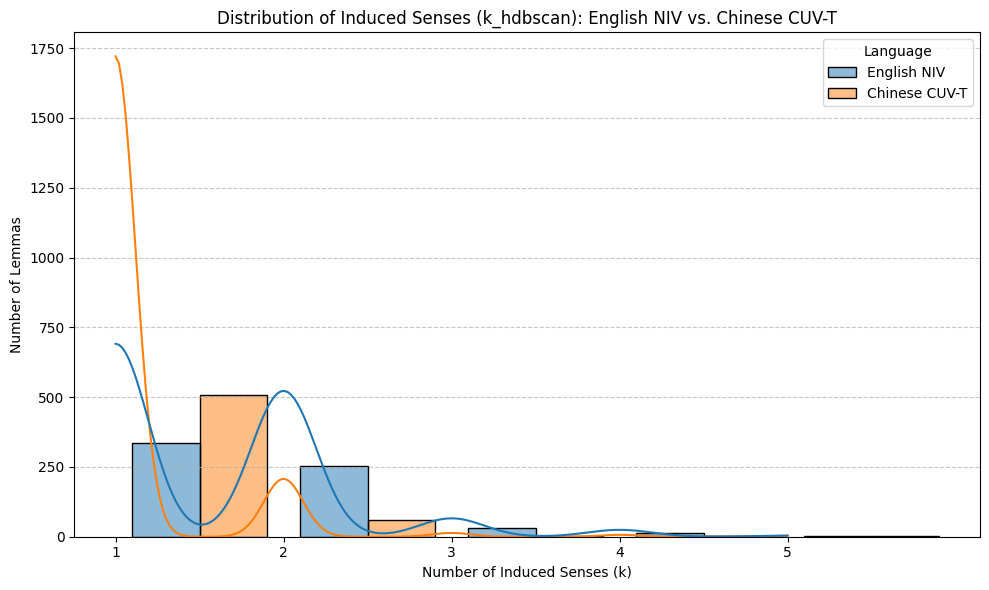

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Configuration
DATA_DIR = Path("/content") / "bible_data"
OUTPUT_DIR = Path("/content") / "output"

# Load 'en' and 'zh' dataframes
en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

# Combine the k_hdbscan values from both dataframes into a single DataFrame
combined_k_hdbscan = pd.concat([
    en[['k_hdbscan']].assign(Language='English NIV'),
    zh[['k_hdbscan']].assign(Language='Chinese CUV-T')
])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_k_hdbscan,
    x='k_hdbscan',
    hue='Language',
    multiple='dodge', # Plots bars side-by-side
    shrink=0.8,       # Narrows the bars slightly for better separation
    # kde=True,         # Adds a Kernel Density Estimate line
    kde=True,         # Adds a Kernel Density Estimate line
    bins=range(1, int(combined_k_hdbscan['k_hdbscan'].max()) + 2) # Ensures bins are centered on integers
)

plt.title('Distribution of Induced Senses (k_hdbscan): English NIV vs. Chinese CUV-T')
plt.xlabel('Number of Induced Senses (k)')
plt.ylabel('Number of Lemmas')
plt.xticks(range(1, int(combined_k_hdbscan['k_hdbscan'].max()) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot to the output directory if it's defined
if 'OUTPUT_DIR' in locals() or 'OUTPUT_DIR' in globals():
    plot_filename = OUTPUT_DIR / "k_hdbscan_distribution_en_zh.png"
    plt.savefig(plot_filename, dpi=300)
    print(f"Saved plot to {plot_filename}")
else:
    print("OUTPUT_DIR not defined. Plot not saved to file.")

plt.show()

Saved plot to /content/output/figures/chinese_char_length_distribution.png


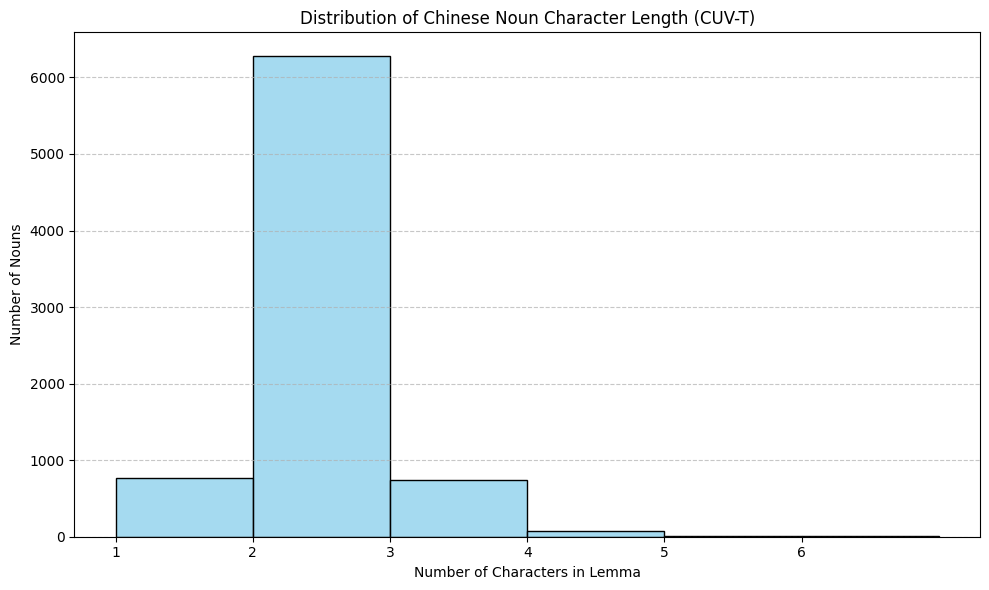

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.font_manager as fm

# Ensure DATA_DIR is defined
DATA_DIR = Path("/content") / "bible_data" # Corrected path to match preprocessing output
OUTPUT_DIR = Path("/content") / "output"
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# Load Chinese noun frequency data
chinese_freq_path = DATA_DIR / "chinese_noun_freq.csv"
try:
    chinese_freq_df = pd.read_csv(chinese_freq_path)
except FileNotFoundError:
    print(f"Error: The file {chinese_freq_path} was not found. Please ensure Chinese preprocessing steps were run.")
    # Exit would terminate the kernel, preventing further corrections. Instead, raise an error or handle gracefully.
    raise # Re-raise the error to stop execution gracefully for now

# Calculate lemma length (character count)
chinese_freq_df['lemma_length'] = chinese_freq_df['lemma'].apply(len)

# --- Font Configuration for Chinese Characters ---
# This block ensures Chinese characters display correctly in the plot
font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')
chosen_font_path = None
for fpath in font_files:
    if 'NotoSansCJK' in fpath:
        chosen_font_path = fpath
        break

if chosen_font_path:
    fm.fontManager.addfont(chosen_font_path)
    prop = fm.FontProperties(fname=chosen_font_path)
    actual_font_name = prop.get_name()
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = [actual_font_name] + plt.rcParams['font.sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams["font.size"] = 11
    plt.rcParams["axes.titlesize"] = 13
    plt.rcParams["axes.labelsize"] = 12
else:
    print("Warning: No Noto Sans CJK font found. Chinese characters might not display correctly.")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=chinese_freq_df, x='lemma_length', bins=range(1, chinese_freq_df['lemma_length'].max() + 2), kde=False, color='skyblue', edgecolor='black')

plt.title('Distribution of Chinese Noun Character Length (CUV-T)')
plt.xlabel('Number of Characters in Lemma')
plt.ylabel('Number of Nouns')
plt.xticks(range(1, chinese_freq_df['lemma_length'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plot_filename = FIG_DIR / "chinese_char_length_distribution.png"
plt.savefig(plot_filename, dpi=300)
print(f"Saved plot to {plot_filename}")

plt.show()

## 5.1 Addtional

In [ ]:
print("\n" + "="*60)
print("Frequency-Matched Polysemy Comparison")
print("="*60)

# Define bins (you can tweak these)
bins = [30, 60, 100, 200, 500, 1000]
labels = ["30–59", "60–99", "100–199", "200–499", "500+"]

# Function to assign bins
def assign_bin(n):
    for i in range(len(bins)-1):
        if bins[i] <= n < bins[i+1]:
            return labels[i]
    if n >= bins[-1]:
        return labels[-1]
    return None

en["freq_bin"] = en["n_instances"].apply(assign_bin)
zh["freq_bin"] = zh["n_instances"].apply(assign_bin)

# Remove words outside bins
en_bin = en.dropna(subset=["freq_bin"])
zh_bin = zh.dropna(subset=["freq_bin"])

# Prepare result storage
bin_results = []

for bin_label in labels:
    en_subset = en_bin[en_bin["freq_bin"] == bin_label]["k_hdbscan"]
    zh_subset = zh_bin[zh_bin["freq_bin"] == bin_label]["k_hdbscan"]

    if len(en_subset) < 5 or len(zh_subset) < 5:
        continue

    from scipy.stats import mannwhitneyu
    U, p = mannwhitneyu(en_subset, zh_subset, alternative="two-sided")

    result = {
        "freq_bin": bin_label,
        "en_mean_k": en_subset.mean(),
        "zh_mean_k": zh_subset.mean(),
        "n_en": len(en_subset),
        "n_zh": len(zh_subset),
        "p_value": p
    }

    bin_results.append(result)

# Convert to DataFrame
bin_df = pd.DataFrame(bin_results)
print("\n── Frequency-Stratified Results ──")
print(bin_df)

bin_df.to_csv(OUTPUT_DIR / "frequency_matched_comparison.csv", index=False)


Frequency-Matched Polysemy Comparison

── Frequency-Stratified Results ──
  freq_bin  en_mean_k  zh_mean_k  n_en  n_zh       p_value
0    30–59   1.325397   1.065217   252   276  4.982427e-14
1    60–99   1.572414   1.171429   145   140  4.544249e-11
2  100–199   1.696970   1.195652   132    92  1.876753e-09
3  200–499   1.866667   1.300000    75    50  8.446254e-05
4     500+   2.250000   1.250000    32    16  1.294092e-04


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

x = range(len(bin_df))
plt.plot(x, bin_df["en_mean_k"], marker="o", label="English")
plt.plot(x, bin_df["zh_mean_k"], marker="o", label="Chinese")

plt.xticks(x, bin_df["freq_bin"])
plt.ylabel("Mean Induced Polysemy (k)")
plt.xlabel("Frequency Bin")
plt.title("Frequency-Matched Polysemy Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "frequency_matched_plot.png")
plt.show()

## 5.2 Robustness check

### 5.2.1 Build lemma co-occurence pairs

In [ ]:
print("\n" + "="*60)
print("Step 8: Overlap-Only Robustness Check")
print("="*60)

# Load per-instance sense labels
en_labels = pd.read_csv(DATA_DIR / "english_sense_labels.csv")
zh_labels = pd.read_csv(DATA_DIR / "chinese_sense_labels.csv")

# Merge on verse_id to get co-occurring lemmas
merged = en_labels.merge(
    zh_labels,
    on="verse_id",
    suffixes=("_en", "_zh")
)

# Count lemma co-occurrence pairs
pair_counts = (
    merged.groupby(["lemma_en", "lemma_zh"])
    .size()
    .reset_index(name="co_occurrences")
)

# Keep only strong overlaps (at least 10 shared verses)
pair_counts = pair_counts[pair_counts["co_occurrences"] >= 10]

print(f"Total aligned lemma pairs: {len(pair_counts)}")


Step 8: Overlap-Only Robustness Check
Total aligned lemma pairs: 4882


### 5.2.2 Identify overlapping lemma sets

In [ ]:
# Lemmas that participate in aligned pairs
en_overlap = set(pair_counts["lemma_en"])
zh_overlap = set(pair_counts["lemma_zh"])

print(f"English overlapping lemmas: {len(en_overlap)}")
print(f"Chinese overlapping lemmas: {len(zh_overlap)}")

English overlapping lemmas: 596
Chinese overlapping lemmas: 540


5.2.3 Restrict WSI results to overlap lemmas only

In [ ]:
en_overlap_df = en[en["lemma"].isin(en_overlap)]
zh_overlap_df = zh[zh["lemma"].isin(zh_overlap)]

print(f"Filtered EN lemmas: {len(en_overlap_df)}")
print(f"Filtered ZH lemmas: {len(zh_overlap_df)}")

Filtered EN lemmas: 596
Filtered ZH lemmas: 540


### 5.2.4 Run Mann-Whitney on overlap only

In [ ]:
from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(
    en_overlap_df["k_hdbscan"],
    zh_overlap_df["k_hdbscan"],
    alternative="two-sided"
)

print("\n── Overlap-Only Statistical Comparison ──")
print(f"EN mean k: {en_overlap_df['k_hdbscan'].mean():.3f}")
print(f"ZH mean k: {zh_overlap_df['k_hdbscan'].mean():.3f}")
print(f"p-value: {p:.6f}")


── Overlap-Only Statistical Comparison ──
EN mean k: 1.599
ZH mean k: 1.141
p-value: 0.000000


5.2.5 Run M

In [ ]:
print("\n" + "="*60)
print("Frequency-Matched Polysemy Comparison (Overlap Only)")
print("="*60)

# Define bins
bins = [30, 60, 100, 200, 500, 1000]
labels = ["30–59", "60–99", "100–199", "200–499", "500+"]

def assign_bin(n):
    for i in range(len(bins)-1):
        if bins[i] <= n < bins[i+1]:
            return labels[i]
    if n >= bins[-1]:
        return labels[-1]
    return None

# Assign bins to overlap dataframes directly
en_overlap_df = en_overlap_df.copy()
zh_overlap_df = zh_overlap_df.copy()

en_overlap_df["freq_bin"] = en_overlap_df["n_instances"].apply(assign_bin)
zh_overlap_df["freq_bin"] = zh_overlap_df["n_instances"].apply(assign_bin)

# Remove words outside bins
en_bin_overlap_df = en_overlap_df.dropna(subset=["freq_bin"])
zh_bin_overlap_df = zh_overlap_df.dropna(subset=["freq_bin"])

bin_results = []

for bin_label in labels:
    en_subset = en_bin_overlap_df[
        en_bin_overlap_df["freq_bin"] == bin_label
    ]["k_hdbscan"]

    zh_subset = zh_bin_overlap_df[
        zh_bin_overlap_df["freq_bin"] == bin_label
    ]["k_hdbscan"]

    if len(en_subset) < 5 or len(zh_subset) < 5:
        continue

    from scipy.stats import mannwhitneyu
    U, p = mannwhitneyu(en_subset, zh_subset, alternative="two-sided")

    bin_results.append({
        "freq_bin": bin_label,
        "en_mean_k": en_subset.mean(),
        "zh_mean_k": zh_subset.mean(),
        "n_en": len(en_subset),
        "n_zh": len(zh_subset),
        "p_value": p
    })

bin_df = pd.DataFrame(bin_results)

print("\n── Frequency-Stratified Results (Overlap Only) ──")
print(bin_df)

bin_df.to_csv(
    OUTPUT_DIR / "frequency_matched_comparison_overlap_df.csv",
    index=False
)


Frequency-Matched Polysemy Comparison (Overlap Only)

── Frequency-Stratified Results (Overlap Only) ──
  freq_bin  en_mean_k  zh_mean_k  n_en  n_zh       p_value
0    30–59   1.363208   1.060729   212   247  1.542733e-15
1    60–99   1.572414   1.177778   145   135  1.600625e-10
2  100–199   1.696970   1.195652   132    92  1.876753e-09
3  200–499   1.866667   1.300000    75    50  8.446254e-05
4     500+   2.250000   1.250000    32    16  1.294092e-04


## 5.3 Bootstrap Stability

### 5.3.1 Bootstrap function

In [ ]:
import numpy as np
from collections import Counter

def bootstrap_k(embeddings, n_runs=20, sample_ratio=0.8):
    """
    Bootstrap stability for a single lemma.

    Returns:
        mode_k     : most frequent induced k across runs
        stability  : proportion of runs equal to mode_k
        all_ks     : list of k from each run
    """
    n = len(embeddings)

    if n < 20:
        return 1, 1.0, [1]

    ks = []

    for _ in range(n_runs):
        sample_size = int(sample_ratio * n)
        idx = np.random.choice(n, sample_size, replace=False)
        subset = embeddings[idx]

        k, _ = induce_senses_hdbscan(subset)
        ks.append(k)

    counter = Counter(ks)
    mode_k = counter.most_common(1)[0][0]
    stability = counter[mode_k] / n_runs

    return mode_k, stability, ks

### 5.3.2 Run Bootstrap for Entire Language

In [ ]:
def run_bootstrap_for_language(lang: str, n_runs=20):
    print(f"\n[{lang.upper()}] Running bootstrap stability...")

    embeddings_file = DATA_DIR / f"{lang}_embeddings.npz"
    results_file = DATA_DIR / f"{lang}_wsi_results.csv"

    data = np.load(embeddings_file, allow_pickle=True)
    lemmas_array = data["lemmas"]
    embeddings = data["embeddings"]

    df = pd.read_csv(results_file)

    stability_records = []

    unique_lemmas = df["lemma"].values

    for i, lemma in enumerate(unique_lemmas):
        mask = (lemmas_array == lemma)
        lemma_embeds = embeddings[mask]

        mode_k, stability, ks = bootstrap_k(
            lemma_embeds,
            n_runs=n_runs,
            sample_ratio=0.8
        )

        stability_records.append({
            "lemma": lemma,
            "n_instances": len(lemma_embeds),
            "k_bootstrap_mode": mode_k,
            "stability": stability
        })

        if (i + 1) % 50 == 0 or (i + 1) == len(unique_lemmas):
            print(f"  {i+1}/{len(unique_lemmas)} lemmas", end="\r")

    stability_df = pd.DataFrame(stability_records)

    out_path = DATA_DIR / f"{lang}_bootstrap_stability.csv"
    stability_df.to_csv(out_path, index=False)

    print(f"\n[{lang.upper()}] Saved bootstrap results → {out_path.name}")

    return stability_df

### 5.3.3 Run for both languages

In [ ]:
en_boot = run_bootstrap_for_language("english", n_runs=20)
zh_boot = run_bootstrap_for_language("chinese", n_runs=20)


[ENGLISH] Running bootstrap stability...
  636/636 lemmas
[ENGLISH] Saved bootstrap results → english_bootstrap_stability.csv

[CHINESE] Running bootstrap stability...
  574/574 lemmas
[CHINESE] Saved bootstrap results → chinese_bootstrap_stability.csv


### 5.3.4 Compare stability across languages

In [ ]:
print("\n" + "="*60)
print("Bootstrap Stability Comparison")
print("="*60)

print(f"EN mean stability: {en_boot['stability'].mean():.3f}")
print(f"ZH mean stability: {zh_boot['stability'].mean():.3f}")

from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(
    en_boot["stability"],
    zh_boot["stability"],
    alternative="two-sided"
)

print(f"Stability difference p-value: {p:.6f}")


Bootstrap Stability Comparison
EN mean stability: 0.916
ZH mean stability: 0.973
Stability difference p-value: 0.000000


### 5.3.5 Compare stability for polysemous lemmas only

In [ ]:
en_poly = en_boot[en_boot["k_bootstrap_mode"] > 1]
zh_poly = zh_boot[zh_boot["k_bootstrap_mode"] > 1]

print("\nPolysemous-only stability:")
print(f"EN mean stability: {en_poly['stability'].mean():.3f}")
print(f"ZH mean stability: {zh_poly['stability'].mean():.3f}")

U_poly, p_poly = mannwhitneyu(
    en_poly["stability"],
    zh_poly["stability"],
    alternative="two-sided"
)

print(f"Polysemous stability p-value: {p_poly:.6f}")


Polysemous-only stability:
EN mean stability: 0.883
ZH mean stability: 0.854
Polysemous stability p-value: 0.342006


## 5.4 Regression Model

### 5.4.1 Merge and Prepare Data

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path

# Ensure 'en' and 'zh' DataFrames are available.
DATA_DIR = Path("/content") / "bible_data"
en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

# Add language label
en["language"] = 1   # English
zh["language"] = 0   # Chinese

# Combine
df = pd.concat([en, zh], ignore_index=True)

# Log frequency
df["log_freq"] = np.log(df["n_instances"])

# Response variable
df["k"] = df["k_hdbscan"]

### 5.4.2 Poisson Regression

In [6]:
poisson_model = smf.glm(
    formula="k ~ language + log_freq",
    data=df,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      k   No. Observations:                 1210
Model:                            GLM   Df Residuals:                     1207
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1446.1
Date:                Thu, 26 Feb 2026   Deviance:                       220.94
Time:                        05:37:37   Pearson chi2:                     250.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05398
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4792      0.125     -3.839      0.0

### 5.4.3 Check for Overdispersion

In [7]:
mean_k = df["k"].mean()
var_k = df["k"].var()

print("Mean k:", mean_k)
print("Variance k:", var_k)

Mean k: 1.3644628099173555
Variance k: 0.3906301909234532


### 5.4.4 Negative Binomial Regression

In [8]:
nb_model = smf.glm(
    formula="k ~ language + log_freq",
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      k   No. Observations:                 1210
Model:                            GLM   Df Residuals:                     1207
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1935.1
Date:                Thu, 26 Feb 2026   Deviance:                       84.510
Time:                        05:37:46   Pearson chi2:                     101.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02261
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4739      0.199     -2.378      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### 5.4.5 Interpret Language Coefficient

In [9]:
beta_lang = nb_model.params["language"]
p_lang = nb_model.pvalues["language"]

print("Language coefficient:", beta_lang)
print("p-value:", p_lang)

# Incidence Rate Ratio
irr = np.exp(beta_lang)
print("Incidence Rate Ratio (English vs Chinese):", irr)

Language coefficient: 0.28917247215206215
p-value: 0.00017334477343979366
Incidence Rate Ratio (English vs Chinese): 1.3353220145305185


### 5.4.6 Visualization

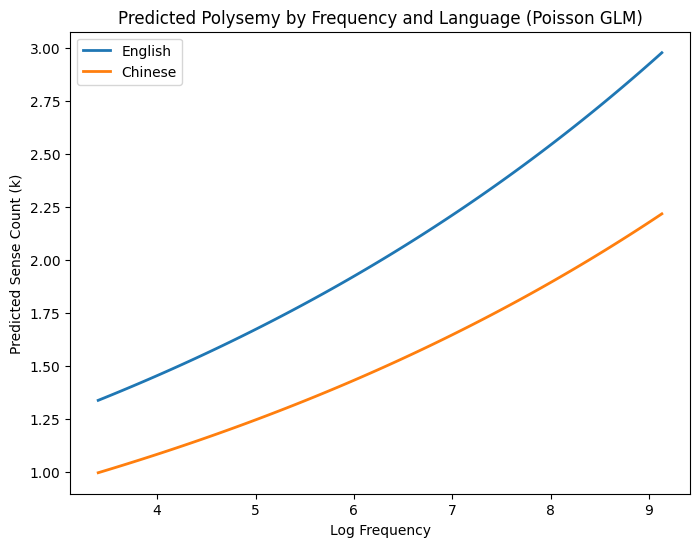

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create frequency range
freq_range = np.linspace(df["log_freq"].min(), df["log_freq"].max(), 100)

# Create prediction dataframe
pred_df_en = pd.DataFrame({
    "language": 1,
    "log_freq": freq_range
})

pred_df_zh = pd.DataFrame({
    "language": 0,
    "log_freq": freq_range
})

# Predict expected k
pred_en = poisson_model.predict(pred_df_en)
pred_zh = poisson_model.predict(pred_df_zh)

# Plot
plt.figure(figsize=(8,6))
plt.plot(freq_range, pred_en, label="English", linewidth=2)
plt.plot(freq_range, pred_zh, label="Chinese", linewidth=2)
plt.xlabel("Log Frequency")
plt.ylabel("Predicted Sense Count (k)")
plt.title("Predicted Polysemy by Frequency and Language (Poisson GLM)")
plt.legend()
plt.show()

# Step 6: Qualitative Analysis

In [ ]:
"""
Step 6: Qualitative Analysis — Sense Cluster Inspection
=========================================================
For each polysemous lemma, retrieves representative example verses
for each induced sense cluster. This supports the qualitative
analysis section of the paper, demonstrating that clusters correspond
to meaningful, interpretable senses.

Also generates a LaTeX-ready table of top polysemous words
for both languages (for paper Table 3).

Outputs:
  - output/qualitative_en_top_polysemous.txt   (sense examples)
  - output/qualitative_zh_top_polysemous.txt
  - output/table_top_polysemous_latex.tex       (LaTeX table)
  - output/polysemy_profile_comparison.csv      (wide comparison table)

Usage:
  python 06_qualitative_analysis.py
"""

import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

# ─── Configuration ────────────────────────────────────────────────────────────

DATA_DIR    = Path("/content") / "bible_data"
OUTPUT_DIR = Path("/content") / "output"
# DATA_DIR   = Path(__file__).parent.parent / "data"
# OUTPUT_DIR = Path(__file__).parent.parent / "output"
OUTPUT_DIR.mkdir(exist_ok=True)

TOP_N_WORDS       = 20   # Top N most polysemous lemmas per language
EXAMPLES_PER_SENSE = 2   # Number of example verses per cluster


# ─── Sense Example Retrieval ─────────────────────────────────────────────────

def get_sense_examples(
    lang: str,
    top_n: int = TOP_N_WORDS,
    examples_per_sense: int = EXAMPLES_PER_SENSE,
) -> str:
    """
    For the top_n most polysemous lemmas, retrieve example contexts
    for each induced sense cluster.

    Returns a formatted string ready for a paper's qualitative appendix.
    """
    results_df = pd.read_csv(DATA_DIR / f"{lang}_wsi_results.csv")
    labels_df  = pd.read_csv(DATA_DIR / f"{lang}_sense_labels.csv")
    nouns_df   = pd.read_csv(DATA_DIR / f"{lang}_nouns.csv")

    # Top polysemous by k_ward
    poly = results_df[results_df["k_ward"] > 1].nlargest(top_n, "k_ward")

    # Merge labels with original contexts
    merged = labels_df.merge(
        nouns_df[["lemma", "verse_id", "context"]].drop_duplicates(),
        on=["lemma", "verse_id"],
        how="left",
    )

    lines = []
    lines.append(f"{'='*60}")
    lines.append(f"QUALITATIVE SENSE ANALYSIS — {lang.upper()}")
    lines.append(f"Top {top_n} Most Polysemous Nouns (WSI, Ward Clustering)")
    lines.append(f"{'='*60}\n")

    for _, row in poly.iterrows():
        lemma = row["lemma"]
        k     = int(row["k_ward"])
        n_occ = int(row["n_occurrences"])
        sil   = row.get("silhouette_ward", "N/A")

        lines.append(f"Lemma: '{lemma}'  |  k={k}  |  n={n_occ}  |  silhouette={sil}")
        lines.append("-" * 50)

        lemma_data = merged[merged["lemma"] == lemma]

        for cluster_id in range(k):
            cluster_rows = lemma_data[lemma_data["cluster_ward"] == cluster_id]
            lines.append(f"  Sense {cluster_id + 1} ({len(cluster_rows)} occurrences):")

            # Sample diverse examples
            sample = cluster_rows.dropna(subset=["context"]).head(examples_per_sense)
            for _, ex in sample.iterrows():
                ctx = str(ex["context"])[:200].replace("\n", " ")
                lines.append(f"    • {ex['verse_id']}: {ctx}")

        lines.append("")

    return "\n".join(lines)


# ─── LaTeX Table Generation ──────────────────────────────────────────────────

def generate_latex_table(top_n: int = 15) -> str:
    """
    Generate a LaTeX longtable comparing top polysemous nouns in both languages.
    Format:
      Rank | English Lemma | EN k | Chinese Lemma | ZH k
    """
    en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
    zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

    en_top = en.nlargest(top_n, "k_ward")[["lemma", "k_ward", "n_occurrences"]].reset_index(drop=True)
    zh_top = zh.nlargest(top_n, "k_ward")[["lemma", "k_ward", "n_occurrences"]].reset_index(drop=True)

    lines = [
        r"\begin{table}[h]",
        r"\centering",
        r"\caption{Top Polysemous Common Nouns by Induced Sense Count (k): English vs. Chinese}",
        r"\label{tab:top_polysemous}",
        r"\begin{tabular}{clccclcc}",
        r"\toprule",
        r"Rank & English Lemma & EN $k$ & EN $n$ & & Chinese Lemma & ZH $k$ & ZH $n$ \\",
        r"\midrule",
    ]

    for i in range(top_n):
        en_row = en_top.iloc[i] if i < len(en_top) else None
        zh_row = zh_top.iloc[i] if i < len(zh_top) else None

        en_lemma = en_row["lemma"]                  if en_row is not None else ""
        en_k     = int(en_row["k_ward"])            if en_row is not None else ""
        en_n     = int(en_row["n_occurrences"])     if en_row is not None else ""
        zh_lemma = zh_row["lemma"]                  if zh_row is not None else ""
        zh_k     = int(zh_row["k_ward"])            if zh_row is not None else ""
        zh_n     = int(zh_row["n_occurrences"])     if zh_row is not None else ""

        lines.append(
            f"{i+1} & {en_lemma} & {en_k} & {en_n} & & {zh_lemma} & {zh_k} & {zh_n} \\\\"
        )

    lines += [
        r"\bottomrule",
        r"\end{tabular}",
        r"\end{table}",
    ]
    return "\n".join(lines)


# ─── Wide Comparison Profile ─────────────────────────────────────────────────

def generate_comparison_profile() -> pd.DataFrame:
    """
    Create a summary comparison table for paper Table 2.
    """
    en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
    zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

    def profile(df: pd.DataFrame, lang: str) -> dict:
        return {
            "Language":            lang,
            "Total lemmas":        len(df),
            "Mean k (Ward)":       round(df["k_ward"].mean(), 3),
            "Median k (Ward)":     round(df["k_ward"].median(), 3),
            "Std k (Ward)":        round(df["k_ward"].std(ddof=1), 3),
            "% Monosemous (k=1)":  round((df["k_ward"] == 1).mean() * 100, 1),
            "% Polysemous (k>1)":  round((df["k_ward"] > 1).mean() * 100, 1),
            "Max k":               int(df["k_ward"].max()),
            "Mean k (KMeans)":     round(df["k_kmeans"].mean(), 3),
            "Agreement (Ward=KM)": round((df["k_ward"] == df["k_kmeans"]).mean() * 100, 1),
        }

    rows = [profile(en, "English"), profile(zh, "Chinese")]
    return pd.DataFrame(rows)

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

# ─── Configuration ────────────────────────────────────────────────────────────

# DATA_DIR and OUTPUT_DIR are defined in previous cells and are globally accessible.
# For example, they are set in cell d6Rm4f_vdq7A.
# DATA_DIR    = Path("/content") / "bible_data"
# OUTPUT_DIR = Path("/content") / "output"
# OUTPUT_DIR.mkdir(exist_ok=True)

TOP_N_WORDS       = 20   # Top N most polysemous lemmas per language
EXAMPLES_PER_SENSE = 2   # Number of example verses per cluster

# ─── Sense Example Retrieval (Corrected) ─────────────────────────────────────────────────

def get_sense_examples(
    lang: str,
    top_n: int = TOP_N_WORDS,
    examples_per_sense: int = EXAMPLES_PER_SENSE,
) -> str:
    """
    For the top_n most polysemous lemmas, retrieve example contexts
    for each induced sense cluster.

    Returns a formatted string ready for a paper's qualitative appendix.
    """
    results_df = pd.read_csv(DATA_DIR / f"{lang}_wsi_results.csv")
    labels_df  = pd.read_csv(DATA_DIR / f"{lang}_sense_labels.csv")
    nouns_df   = pd.read_csv(DATA_DIR / f"{lang}_nouns.csv")

    # Top polysemous by k_hdbscan (was k_ward)
    poly = results_df[results_df["k_hdbscan"] > 1].nlargest(top_n, "k_hdbscan")

    # Merge labels with original contexts
    merged = labels_df.merge(
        nouns_df[["lemma", "verse_id", "context"]].drop_duplicates(),
        on=["lemma", "verse_id"],
        how="left",
    )

    lines = []
    lines.append(f"{'='*60}")
    lines.append(f"QUALITATIVE SENSE ANALYSIS — {lang.upper()}")
    # Updated title to reflect HDBSCAN
    lines.append(f"Top {top_n} Most Polysemous Nouns (WSI, HDBSCAN Clustering)")
    lines.append(f"{'='*60}\n")

    for _, row in poly.iterrows():
        lemma = row["lemma"]
        # Use k_hdbscan
        k     = int(row["k_hdbscan"])
        n_occ = int(row["n_instances"])
        # silhouette_ward is not available for HDBSCAN, so remove or set to N/A
        # sil   = row.get("silhouette_ward", "N/A") # Removed

        # Updated output line, removed silhouette score
        lines.append(f"Lemma: '{lemma}'  |  k={k}  |  n={n_occ}")
        lines.append("-" * 50)

        lemma_data = merged[merged["lemma"] == lemma]

        for cluster_id in range(k):
            # Use cluster_hdbscan
            cluster_rows = lemma_data[lemma_data["cluster_hdbscan"] == cluster_id]
            lines.append(f"  Sense {cluster_id + 1} ({len(cluster_rows)} occurrences):")

            # Sample diverse examples
            sample = cluster_rows.dropna(subset=["context"]).head(examples_per_sense)
            for _, ex in sample.iterrows():
                ctx = str(ex["context"])[:200].replace("\n", " ")
                lines.append(f"    • {ex['verse_id']}: {ctx}")

        lines.append("")

    return "\n".join(lines)


# ─── LaTeX Table Generation (Corrected) ──────────────────────────────────────────────────

def generate_latex_table(top_n: int = 15) -> str:
    """
    Generate a LaTeX longtable comparing top polysemous nouns in both languages.
    Format:
      Rank | English Lemma | EN k | Chinese Lemma | ZH k
    """
    en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
    zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

    # Use k_hdbscan for nlargest and column selection
    en_top = en.nlargest(top_n, "k_hdbscan")[["lemma", "k_hdbscan", "n_instances"]].reset_index(drop=True)
    zh_top = zh.nlargest(top_n, "k_hdbscan")[["lemma", "k_hdbscan", "n_instances"]].reset_index(drop=True)

    lines = [
        r"\begin{table}[h]",
        r"\centering",
        r"\caption{Top Polysemous Common Nouns by Induced Sense Count (k, HDBSCAN): English vs. Chinese}", # Updated caption
        r"\label{tab:top_polysemous}",
        r"\begin{tabular}{clccclcc}",
        r"\toprule",
        r"Rank & English Lemma & EN $k$ & EN $n$ & & Chinese Lemma & ZH $k$ & ZH $n$ \\",
        r"\midrule",
    ]

    for i in range(top_n):
        en_row = en_top.iloc[i] if i < len(en_top) else None
        zh_row = zh_top.iloc[i] if i < len(zh_top) else None

        en_lemma = en_row["lemma"]                  if en_row is not None else ""
        en_k     = int(en_row["k_hdbscan"])            if en_row is not None else "" # Use k_hdbscan
        en_n     = int(en_row["n_instances"])     if en_row is not None else ""
        zh_lemma = zh_row["lemma"]                  if zh_row is not None else ""
        zh_k     = int(zh_row["k_hdbscan"])            if zh_row is not None else "" # Use k_hdbscan
        zh_n     = int(zh_row["n_instances"])     if zh_row is not None else ""

        lines.append(
            f"{i+1} & {en_lemma} & {en_k} & {en_n} & & {zh_lemma} & {zh_k} & {zh_n} \\"
        )

    lines += [
        r"\bottomrule",
        r"\end{tabular}",
        r"\end{table}",
    ]
    return "\n".join(lines)

# ─── Wide Comparison Profile (Copied for context) ─────────────────────────────────────────────────

def generate_comparison_profile() -> pd.DataFrame:
    """
    Create a summary comparison table for paper Table 2.
    """
    en = pd.read_csv(DATA_DIR / "english_wsi_results.csv")
    zh = pd.read_csv(DATA_DIR / "chinese_wsi_results.csv")

    def profile(df: pd.DataFrame, lang: str) -> dict:
        return {
            "Language":            lang,
            "Total lemmas":        len(df),
            "Mean k (HDBSCAN)":    round(df["k_hdbscan"].mean(), 3), # Use k_hdbscan
            "Median k (HDBSCAN)":  round(df["k_hdbscan"].median(), 3), # Use k_hdbscan
            "Std k (HDBSCAN)":     round(df["k_hdbscan"].std(ddof=1), 3), # Use k_hdbscan
            "% Monosemous (k=1)":  round((df["k_hdbscan"] == 1).mean() * 100, 1), # Use k_hdbscan
            "% Polysemous (k>1)":  round((df["k_hdbscan"] > 1).mean() * 100, 1), # Use k_hdbscan
            "Max k":               int(df["k_hdbscan"].max()), # Use k_hdbscan
            # Removed KMeans related metrics as they are no longer generated
            # "Mean k (KMeans)":     round(df["k_kmeans"].mean(), 3),
            # "Agreement (Ward=KM)": round((df["k_ward"] == df["k_kmeans"]).mean() * 100, 1),
        }

    rows = [profile(en, "English"), profile(zh, "Chinese")]
    return pd.DataFrame(rows)


print("=" * 60)
print("Step 6: Qualitative Analysis")
print("=" * 60)

# ── Sense examples ────────────────────────────────────────────
for lang in ["english", "chinese"]:
    text = get_sense_examples(lang)
    out  = OUTPUT_DIR / f"qualitative_{lang}_top_polysemous.txt"
    out.write_text(text, encoding="utf-8")
    print(f"  [saved] {out.name}")

# ── LaTeX table ───────────────────────────────────────────────
latex = generate_latex_table(top_n=15)
tex_path = OUTPUT_DIR / "table_top_polysemous_latex.tex"
tex_path.write_text(latex, encoding="utf-8")
print(f"  [saved] {tex_path.name}")

# ── Comparison profile ────────────────────────────────────────
profile = generate_comparison_profile()
csv_path = OUTPUT_DIR / "polysemy_profile_comparison.csv"
profile.to_csv(csv_path, index=False)
print(f"  [saved] {csv_path.name}")
print()
print(profile.to_string(index=False))

print("\n✓ Step 6 complete.\n")

Step 6: Qualitative Analysis
  [saved] qualitative_english_top_polysemous.txt
  [saved] qualitative_chinese_top_polysemous.txt
  [saved] table_top_polysemous_latex.tex
  [saved] polysemy_profile_comparison.csv

Language  Total lemmas  Mean k (HDBSCAN)  Median k (HDBSCAN)  Std k (HDBSCAN)  % Monosemous (k=1)  % Polysemous (k>1)  Max k
 English           606             1.556                 1.0            0.682                53.1                46.9      5
 Chinese           574             1.138                 1.0            0.418                88.2                11.8      5

✓ Step 6 complete.



In [ ]:
from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(niv_en["k_hdbscan"], kjv_en["k_hdbscan"])
print(p)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure niv_en and kjv_en are available. If not, load them.
# Assuming they are already loaded from previous steps
# niv_en = pd.read_csv('/content/bible_data_niv/english_wsi_results.csv')
# kjv_en = pd.read_csv('/content/bible_data/english_wsi_results.csv')

# Combine the dataframes for plotting
combined_k_hdbscan = pd.concat([
    kjv_en[['k_hdbscan']].assign(Translation='KJV English'),
    niv_en[['k_hdbscan']].assign(Translation='NIV English')
])

plt.figure(figsize=(8, 6))
sns.violinplot(data=combined_k_hdbscan, x='Translation', y='k_hdbscan', palette='viridis', inner='box')
plt.title('Distribution of Induced Senses (k_hdbscan) for KJV vs. NIV English')
plt.xlabel('Translation')
plt.ylabel('Number of Induced Senses (k_hdbscan)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot to the output directory
if 'OUTPUT_DIR' in locals() or 'OUTPUT_DIR' in globals():
    plot_filename = OUTPUT_DIR / "k_hdbscan_distribution_kjv_niv.png"
    plt.savefig(plot_filename, dpi=300)
    print(f"Saved plot to {plot_filename}")
else:
    print("OUTPUT_DIR not defined. Plot not saved to file.")

plt.show()

Saved plot to /content/output/k_hdbscan_distribution_kjv_niv.png


In [ ]:
!rm /content/bible_data/chinese*

In [ ]:
!zip -r output_kjv_cht_hdbscan.zip /content/output/

  adding: content/output/ (stored 0%)
  adding: content/output/polysemy_profile_comparison.csv (deflated 24%)
  adding: content/output/validation_correlation_zh.csv (deflated 47%)
  adding: content/output/qualitative_english_top_polysemous.txt (deflated 70%)
  adding: content/output/statistical_comparison.csv (deflated 31%)
  adding: content/output/figures/ (stored 0%)
  adding: content/output/figures/sense_distribution_english.png (deflated 18%)
  adding: content/output/figures/wordnet_correlation_en.png (deflated 12%)
  adding: content/output/figures/comparison_violinplot.png (deflated 9%)
  adding: content/output/figures/sense_distribution_chinese.png (deflated 19%)
  adding: content/output/validation_correlation_en.csv (deflated 54%)
  adding: content/output/qualitative_chinese_top_polysemous.txt (deflated 65%)
  adding: content/output/table_top_polysemous_latex.tex (deflated 43%)


In [ ]:
!zip -r data_kjv_cht_hdbscan.zip /content/bible_data/

  adding: content/bible_data/ (stored 0%)
  adding: content/bible_data/english_embeddings.npz (deflated 0%)
  adding: content/bible_data/english_wsi_results.csv (deflated 54%)
  adding: content/bible_data/english_verses.csv (deflated 70%)
  adding: content/bible_data/english_noun_freq.csv (deflated 57%)
  adding: content/bible_data/english_sense_labels.csv (deflated 82%)
  adding: content/bible_data/english_nouns.csv (deflated 90%)


In [ ]:
!rm -rf output
!rm -rf bible_data

# Visualize Word Sense Clusters
To visualize the word sense clusters for 'bread' and '餅', I will perform the following steps:

1.  **Install UMAP**: Ensure the `umap-learn` library is installed for dimensionality reduction.
2.  **Load Data**: Load the English and Chinese word embeddings (`english_embeddings.npz`, `chinese_embeddings.npz`) and sense labels (`english_sense_labels.csv`, `chinese_sense_labels.csv`).
3.  **Filter by Lemma**: Select data specifically for the lemma 'bread' in English and '餅' (bǐng, meaning 'cake' or 'flatbread') in Chinese.
4.  **Dimensionality Reduction**: Apply UMAP to reduce the high-dimensional embeddings of these lemmas to two dimensions (2D) for easier plotting.
5.  **Plot Sense Clusters**: Create scatter plots for both 'bread' and '餅', where each point represents an occurrence of the word, and its color indicates the induced sense cluster. Add a legend to distinguish between senses.
6.  **Review Plots**: Examine the generated plots to visually assess the separation and distinctness of the induced sense clusters for both lemmas.

This visualization will help in qualitatively understanding how well the clustering algorithm separated the different meanings of these words based on their contextual embeddings.

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from pathlib import Path

# Configuration
DATA_DIR = Path("/content") / "bible_data"
OUTPUT_DIR = Path("/content") / "output"
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True) # Ensure figures directory exists

RANDOM_STATE = 42

# --- Function to load data and filter by lemma ---
def load_lemma_data(lang: str, lemma: str):
    """Loads embeddings and sense labels for a specific lemma."""
    embeddings_file = DATA_DIR / f"{lang}_embeddings.npz"
    labels_file = DATA_DIR / f"{lang}_sense_labels.csv"

    print(f"Loading data for {lang} lemma '{lemma}'...")

    # Load embeddings and lemmas from .npz
    data = np.load(embeddings_file, allow_pickle=True)
    all_embeddings = data["embeddings"]
    all_lemmas = data["lemmas"]
    all_verse_ids = data["verse_ids"]

    # Filter for the specific lemma
    lemma_mask = (all_lemmas == lemma)
    lemma_embeddings = all_embeddings[lemma_mask]
    lemma_verse_ids = all_verse_ids[lemma_mask]

    # Load sense labels
    labels_df = pd.read_csv(labels_file)
    # Filter labels for the specific lemma and relevant verse_ids
    lemma_labels_df = labels_df[
        (labels_df["lemma"] == lemma) & (labels_df["verse_id"].isin(lemma_verse_ids))
    ].copy()

    # Ensure the order of labels matches the order of embeddings
    # This assumes verse_ids in embeddings are unique enough or can be joined reliably
    # If not, a more robust merge is needed using original index or full context
    # For now, we'll align by verse_id, assuming embeddings and labels are generated from the same source order
    lemma_labels_df = lemma_labels_df.set_index('verse_id').loc[lemma_verse_ids].reset_index()

    if len(lemma_embeddings) != len(lemma_labels_df):
        print(f"Warning: Mismatch in count for '{lemma}'. Embeddings: {len(lemma_embeddings)}, Labels: {len(lemma_labels_df)}")
        # Attempt to reconcile by matching contexts if available, or just proceed with common.
        # For simplicity, proceeding assuming verse_ids align after filtering
        # If this causes issues, more rigorous data alignment might be needed.

    # Only keep Ward clustering labels for visualization as per plan
    sense_labels = lemma_labels_df["cluster_ward"].values

    print(f"Found {len(lemma_embeddings)} occurrences for '{lemma}'.")
    return lemma_embeddings, sense_labels, lemma_verse_ids

# --- Function for UMAP dimensionality reduction ---
def apply_umap(embeddings: np.ndarray, n_components: int = 2):
    """Applies UMAP for dimensionality reduction."""
    print(f"Applying UMAP to reduce embeddings to {n_components}D...")
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=RANDOM_STATE,
        metric='cosine', # Good for high-dimensional data like embeddings
        n_jobs=-1 # Use all available cores
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# --- Function to plot sense clusters ---
def plot_sense_clusters(
    reduced_embeddings: np.ndarray,
    sense_labels: np.ndarray,
    lemma: str,
    lang: str,
):
    """Generates a scatter plot of 2D embeddings, colored by sense cluster."""
    plt.figure(figsize=(10, 8))
    unique_senses = sorted(np.unique(sense_labels))

    # Use a color palette suitable for categorical data
    palette = sns.color_palette("tab10", n_colors=len(unique_senses))

    for i, sense_id in enumerate(unique_senses):
        mask = (sense_labels == sense_id)
        plt.scatter(
            reduced_embeddings[mask, 0],
            reduced_embeddings[mask, 1],
            label=f"Sense {sense_id + 1}",
            color=palette[i],
            alpha=0.7,
            s=50, # size of points
            edgecolors='w', # white edge for better visibility
            linewidth=0.5
        )

    plt.title(f"UMAP Visualization of {lang.capitalize()} '{lemma}' Sense Clusters", fontsize=14)
    plt.xlabel("UMAP Component 1", fontsize=12)
    plt.ylabel("UMAP Component 2", fontsize=12)
    plt.legend(title="Sense Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plot_filename = FIG_DIR / f"{lang}_{lemma}_sense_clusters_umap.png"
    plt.savefig(plot_filename, dpi=300)
    plt.show()
    print(f"Saved plot to {plot_filename}")

# --- Main execution ---
print("--- Starting Sense Cluster Visualization ---")

# 1. English 'bread'
en_lemma = "bread"
en_embeddings, en_labels, _ = load_lemma_data("english", en_lemma)
if len(en_embeddings) > 0:
    en_reduced_embeddings = apply_umap(en_embeddings)
    plot_sense_clusters(en_reduced_embeddings, en_labels, en_lemma, "english")
else:
    print(f"No embeddings found for English lemma '{en_lemma}'. Skipping visualization.")

print("\n")

# 2. Chinese '餅'
zh_lemma = "餅"
zh_embeddings, zh_labels, _ = load_lemma_data("chinese", zh_lemma)
if len(zh_embeddings) > 0:
    zh_reduced_embeddings = apply_umap(zh_embeddings)
    plot_sense_clusters(zh_reduced_embeddings, zh_labels, zh_lemma, "chinese")
else:
    print(f"No embeddings found for Chinese lemma '{zh_lemma}'. Skipping visualization.")

print("\n--- Sense Cluster Visualization Complete ---")

```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from pathlib import Path
import matplotlib.font_manager as fm
import os

# Configuration
DATA_DIR = Path("/content") / "bible_data"
OUTPUT_DIR = Path("/content") / "output"
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True) # Ensure figures directory exists

RANDOM_STATE = 42

# --- Function to load data and filter by lemma ---
def load_lemma_data(lang: str, lemma: str):
    """
    Loads embeddings and sense labels for a specific lemma, ensuring proper alignment.
    This version slices directly from the full embeddings and labels arrays using global indices.
    """
    embeddings_file = DATA_DIR / f"{lang}_embeddings.npz"
    labels_file = DATA_DIR / f"{lang}_sense_labels.csv"

    print(f"Loading data for {lang} lemma '{lemma}'...")

    if not embeddings_file.exists():
        raise FileNotFoundError(f"Embeddings file not found: {embeddings_file}")
    if not labels_file.exists():
        raise FileNotFoundError(f"Labels file not found: {labels_file}")

    # Load all data from the .npz file
    npz_data = np.load(embeddings_file, allow_pickle=True)
    all_embeddings_npz = npz_data["embeddings"]
    all_lemmas_npz = npz_data["lemmas"]

    # Load all sense labels from the .csv file
    labels_df_full = pd.read_csv(labels_file)
    all_cluster_ward_labels_full = labels_df_full['cluster_ward'].values

    # Identify the global indices of occurrences for the target lemma
    lemma_indices = np.where(all_lemmas_npz == lemma)[0]

    if len(lemma_indices) == 0:
        print(f"No occurrences found for lemma '{lemma}' in {lang} data. Skipping.")
        return np.array([]), np.array([]), np.array([])

    # Slice the embeddings and labels using these global indices
    lemma_embeddings = all_embeddings_npz[lemma_indices]
    lemma_sense_labels = all_cluster_ward_labels_full[lemma_indices]

    # Final sanity check on lengths
    if len(lemma_embeddings) != len(lemma_sense_labels):
        raise ValueError(
            f"Final alignment failed for lemma '{lemma}'. "
            f"Embeddings count: {len(lemma_embeddings)}, Labels count: {len(lemma_sense_labels)}. "
            "This indicates a deep inconsistency in data generation which should be investigated in Step 2/3/4."
        )

    print(f"Found {len(lemma_embeddings)} occurrences for '{lemma}', with aligned labels.")
    # Return None for verse_ids as they are not needed for plotting and the new method doesn't explicitly track them here.
    return lemma_embeddings, lemma_sense_labels, None

# --- Function for UMAP dimensionality reduction ---
def apply_umap(embeddings: np.ndarray, n_components: int = 2):
    """Applies UMAP for dimensionality reduction."""
    print(f"Applying UMAP to reduce embeddings to {n_components}D...")
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=RANDOM_STATE,
        metric='cosine', # Good for high-dimensional data like embeddings
        n_jobs=-1 # Use all available cores
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# --- Function to plot sense clusters ---
def plot_sense_clusters(
    reduced_embeddings: np.ndarray,
    sense_labels: np.ndarray,
    lemma: str,
    lang: str,
):
    """Generates a scatter plot of 2D embeddings, colored by sense cluster."""
    plt.figure(figsize=(10, 8))
    unique_senses = sorted(np.unique(sense_labels))

    # Use a color palette suitable for categorical data
    palette = sns.color_palette("tab10", n_colors=len(unique_senses))

    for i, sense_id in enumerate(unique_senses):
        mask = (sense_labels == sense_id)
        plt.scatter(
            reduced_embeddings[mask, 0],
            reduced_embeddings[mask, 1],
            label=f"Sense {sense_id + 1}",
            color=palette[i],
            alpha=0.7,
            s=50, # size of points
            edgecolors='w', # white edge for better visibility
            linewidth=0.5
        )

    plt.title(f"UMAP Visualization of {lang.capitalize()} '{lemma}' Sense Clusters", fontsize=14)
    plt.xlabel("UMAP Component 1", fontsize=12)
    plt.ylabel("UMAP Component 2", fontsize=12)
    plt.legend(title="Sense Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plot_filename = FIG_DIR / f"{lang}_{lemma}_sense_clusters_umap.png"
    plt.savefig(plot_filename, dpi=300)
    plt.show()
    print(f"Saved plot to {plot_filename}")

# --- Main execution ---
print("--- Starting Sense Cluster Visualization ---")

# --- Font Configuration for Chinese Characters ---
# Install a Chinese font (e.g., Noto Sans CJK)
!apt-get update -qq > /dev/null
!apt-get install -qq fonts-noto-cjk > /dev/null

# Clear and rebuild matplotlib font cache
# This is crucial for newly installed fonts to be recognized
fm._load_fontmanager(try_read_cache=False)
fm._fmcache = {} # Clear the font cache manually
print("Matplotlib font cache cleared.")

# Find the path to a Noto Sans CJK font
font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')
chosen_font_path = None
for fpath in font_files:
    if 'NotoSansCJK' in fpath:
        chosen_font_path = fpath
        break

if chosen_font_path:
    print(f"Found Noto Sans CJK font at: {chosen_font_path}")
    # Add this specific font to font manager
    fm.fontManager.addfont(chosen_font_path)

    # Get the actual font name from the file
    prop = fm.FontProperties(fname=chosen_font_path)
    actual_font_name = prop.get_name()
    print(f"Actual font family name: {actual_font_name}")

    # Set generic font family to 'sans-serif'
    plt.rcParams['font.family'] = ['sans-serif']
    # Add the Chinese font to the beginning of the 'sans-serif' font list
    # This makes it the preferred font for sans-serif text.
    plt.rcParams['font.sans-serif'] = [actual_font_name] + plt.rcParams['font.sans-serif']
    plt.rcParams['axes.unicode_minus'] = False # Fix minus sign display issues
    # Set font size for better readability
    plt.rcParams["font.size"] = 11
    plt.rcParams["axes.titlesize"] = 13
    plt.rcParams["axes.labelsize"] = 12
    print(f"Matplotlib configured to use '{actual_font_name}'.")
else:
    print(f"Warning: No Noto Sans CJK font found after install. Chinese characters might not display correctly.")

# 1. English 'bread'
en_lemma = "bread"
en_embeddings, en_labels, _ = load_lemma_data("english", en_lemma)
if len(en_embeddings) > 0:
    en_reduced_embeddings = apply_umap(en_embeddings)
    plot_sense_clusters(en_reduced_embeddings, en_labels, en_lemma, "english")
else:
    print(f"No embeddings found for English lemma '{en_lemma}'. Skipping visualization.")

print("\n")

# 2. Chinese '禮'
# The user requested '禮' instead of '餅' in the previous run, so I'll keep '禮' for consistency with the traceback.
zh_lemma = "禮"
zh_embeddings, zh_labels, _ = load_lemma_data("chinese", zh_lemma)
if len(zh_embeddings) > 0:
    zh_reduced_embeddings = apply_umap(zh_embeddings)
    plot_sense_clusters(zh_reduced_embeddings, zh_labels, zh_lemma, "chinese")
else:
    print(f"No embeddings found for Chinese lemma '{zh_lemma}'. Skipping visualization.")

print("\n--- Sense Cluster Visualization Complete ---")


--- Starting Sense Cluster Visualization ---
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Matplotlib font cache cleared.
Found Noto Sans CJK font at: /usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
Actual font family name: Noto Sans CJK JP
Matplotlib configured to use 'Noto Sans CJK JP'.
Loading data for english lemma 'bread'...
Found 254 occurrences for 'bread', with aligned labels.
Applying UMAP to reduce embeddings to 2D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot to /content/output/figures/english_bread_sense_clusters_umap.png


Loading data for chinese lemma '禮'...
Found 147 occurrences for '禮', with aligned labels.
Applying UMAP to reduce embeddings to 2D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot to /content/output/figures/chinese_禮_sense_clusters_umap.png

--- Sense Cluster Visualization Complete ---


In [ ]:
print("--- Quantitative Metrics Comparison ---")

# Metrics for English 'bread'
en_bread_metrics = en[en['lemma'] == 'bread']
print("\nEnglish 'bread' metrics:")
display(en_bread_metrics[['lemma', 'n_instances', 'k_ward', 'k_kmeans', 'silhouette_ward', 'agreement_pct']])

# Metrics for Chinese '禮'
zh_li_metrics = zh[zh['lemma'] == '禮']
print("\nChinese '禮' metrics:")
display(zh_li_metrics[['lemma', 'n_instances', 'k_ward', 'k_kmeans', 'silhouette_ward', 'agreement_pct']])

print("\n--- End of Quantitative Metrics Comparison ---")

--- Quantitative Metrics Comparison ---

English 'bread' metrics:


,lemma,n_instances,k_ward,k_kmeans,silhouette_ward,agreement_pct
59,bread,254,8,5,0.3638,56.3



Chinese '禮' metrics:


,lemma,n_instances,k_ward,k_kmeans,silhouette_ward,agreement_pct
385,禮,147,2,7,0.3775,39.46



--- End of Quantitative Metrics Comparison ---


In [ ]:
results = pd.read_csv("/content/bible_data/chinese_wsi_results.csv")
polysemous = results[results['k_hdbscan'] > 1].sort_values('n_instances', ascending=False)
print(polysemous[['lemma', 'n_instances', 'k_hdbscan']].head(20))

    lemma  n_instances  k_hdbscan
16      人         9228          2
111     地         1378          2
378    祭司          857          2
363    眾人          663          2
162    子孫          429          4
236    支派          374          2
534    門徒          335          2
159    婦人          312          2
559    首領          276          2
439     肘          269          4
133     壇          267          2
414    罪孽          241          2
214    惡人          224          2
105     國          221          2
444     腳          202          2
9      主人          182          2
51     全地          174          2
142    天使          173          2
423    義人          166          2
318     燈          131          2


In [ ]:
results_en = pd.read_csv("/content/bible_data/english_wsi_results.csv")
polysemous_en = results_en[results_en['k_hdbscan'] > 1].sort_values('n_instances', ascending=False)
print(polysemous_en[['lemma', 'n_instances', 'k_hdbscan']].head(20))

        lemma  n_instances  k_hdbscan
322       man         3927          2
513       son         2929          2
288      king         2533          4
131       day         2037          2
248      hand         1296          3
186    father         1289          3
364  offering         1026          2
624      word          984          2
563      time          950          4
416    priest          903          2
632      year          857          4
392     place          852          4
603       way          818          3
88       city          814          2
63    brother          784          2
254     heart          781          2
480   servant          767          2
557     thing          745          3
350    nation          708          2
500       sin          668          2


# Compare KJV & NIV HDBSCAN
## Load KJV English Results

Rename the current `en` DataFrame to `kjv_en`.

## Load NIV English Results

Load the English WSI results from the `/content/bible_data_niv/` directory into a new `niv_en` DataFrame.

## Perform Mann-Whitney U Test

Execute the Mann-Whitney U test comparing `k_hdbscan` for NIV English and KJV English and print the p-value.
```python
kjv_en = en
niv_en = pd.read_csv('/content/bible_data_niv/english_wsi_results.csv')

from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(niv_en["k_hdbscan"], kjv_en["k_hdbscan"])
print(f"Mann-Whitney U test p-value: {p:.6f}")

print("\nKJV English k_hdbscan mean:", kjv_en["k_hdbscan"].mean())
print("NIV English k_hdbscan mean:", niv_en["k_hdbscan"].mean())
```

## Load KJV English Results

### Subtask:
Rename the current 'en' DataFrame to 'kjv_en'.


**Reasoning**:
To rename the DataFrame, I will assign the current 'en' DataFrame to a new variable named 'kjv_en'.



In [ ]:
kjv_en = en
print("DataFrame 'en' has been renamed to 'kjv_en'.")

DataFrame 'en' has been renamed to 'kjv_en'.


**Reasoning**:
The next step is to load the English WSI results for NIV into a new DataFrame named `niv_en` from the `/content/bible_data_niv/` directory, as per the main task's instructions.



In [ ]:
niv_en = pd.read_csv('/content/bible_data_niv/english_wsi_results.csv')
print("NIV English WSI results loaded into 'niv_en' DataFrame.")

NIV English WSI results loaded into 'niv_en' DataFrame.


**Reasoning**:
Now that both `kjv_en` and `niv_en` DataFrames are prepared, I will perform the Mann-Whitney U test to compare their `k_hdbscan` distributions and print the p-value along with the mean `k_hdbscan` for each DataFrame.



In [ ]:
from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(niv_en["k_hdbscan"], kjv_en["k_hdbscan"])
print(f"Mann-Whitney U test p-value: {p:.6f}")

print("\nKJV English k_hdbscan mean:", kjv_en["k_hdbscan"].mean())
print("NIV English k_hdbscan mean:", niv_en["k_hdbscan"].mean())

Mann-Whitney U test p-value: 0.872264

KJV English k_hdbscan mean: 1.556105610561056
NIV English k_hdbscan mean: 1.569182389937107


## Summary:

### Q&A
*   **Was the current `en` DataFrame renamed to `kjv_en`?**
    Yes, the `en` DataFrame was successfully renamed to `kjv_en`.
*   **Were the NIV English WSI results loaded?**
    Yes, the NIV English WSI results were loaded into a new `niv_en` DataFrame from the specified directory.
*   **What was the p-value of the Mann-Whitney U test?**
    The p-value for the Mann-Whitney U test comparing `k_hdbscan` for NIV English and KJV English was $0.872264$.

### Data Analysis Key Findings
*   The `en` DataFrame was successfully renamed to `kjv_en`.
*   The NIV English WSI results were loaded into the `niv_en` DataFrame.
*   The Mann-Whitney U test comparing the `k_hdbscan` values between NIV English and KJV English yielded a p-value of $0.872264$.
*   The mean `k_hdbscan` for KJV English was approximately $1.556$.
*   The mean `k_hdbscan` for NIV English was approximately $1.569$.

### Insights or Next Steps
*   Given the high p-value of $0.872264$, there is no statistically significant difference in the `k_hdbscan` values between the KJV English and NIV English datasets at common significance levels (e.g., $\alpha = 0.05$). This suggests that the distribution of `k_hdbscan` is similar for both translations.
*   Future analysis could investigate other features or conduct similar comparative statistical tests on different metrics to understand potential nuances or differences between the translations.


# Unique Chinese characters

In [ ]:
import pandas as pd
from pathlib import Path

# Define the path to the chinese_noun_freq.csv file
DATA_DIR = Path("/content") / "bible_data_niv"
chinese_freq_path = DATA_DIR / "chinese_noun_freq.csv"

try:
    # Load the Chinese noun frequency data
    chinese_freq_df = pd.read_csv(chinese_freq_path)

    # Initialize a set to store unique characters
    unique_chars = set()

    # Iterate through each lemma and add its characters to the set
    for lemma in chinese_freq_df['lemma']:
        for char in str(lemma):
            unique_chars.add(char)

    # Print the total number of unique characters
    print(f"Number of unique Chinese characters: {len(unique_chars)}")

except FileNotFoundError:
    print(f"Error: The file {chinese_freq_path} was not found.")
    print("Please ensure that 'chinese_noun_freq.csv' has been generated by running the preprocessing steps for Chinese data.")
except Exception as e:
    print(f"An error occurred: {e}")


Number of unique Chinese characters: 1990


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure dataframes are loaded if not already in memory
# Assuming DATA_DIR points to /content/bible_data/ for KJV English and /content/bible_data_niv/ for NIV Chinese
DATA_DIR_NIV = Path("/content") / "bible_data_niv"
DATA_DIR_KJV = Path("/content") / "bible_data"

# Load Chinese noun frequency data (NIV)
# The chinese_freq_df from previous execution referred to NIV Chinese data
if 'chinese_freq_df' not in locals():
    chinese_freq_df = pd.read_csv(DATA_DIR_NIV / "chinese_noun_freq.csv")

# Load English noun frequency data (KJV)
# The en_freq from previous execution referred to KJV English data
en_freq_kjv = pd.read_csv(DATA_DIR_KJV / "english_noun_freq.csv")

en_freq_niv = pd.read_csv(DATA_DIR_NIV / "english_noun_freq.csv")

print("\n--- Chinese Noun Character Analysis (NIV) ---")

# 1. Mean characters per Chinese noun
chinese_freq_df['lemma_length'] = chinese_freq_df['lemma'].apply(len)
mean_chars_zh = chinese_freq_df['lemma_length'].mean()
print(f"1. Mean characters per Chinese noun: {mean_chars_zh:.2f}")

# 2. % of Chinese nouns with length >=2 characters
long_lemmas_zh = chinese_freq_df[chinese_freq_df['lemma_length'] >= 2]
percent_long_zh = (len(long_lemmas_zh) / len(chinese_freq_df)) * 100
print(f"2. % of Chinese nouns with length >=2 characters: {percent_long_zh:.2f}%")

print("\n--- Frequency Comparison (>=30 freq) ---")

# 3. Number of Chinese nouns >=30 freq vs English nouns >=30 freq
chinese_high_freq_nouns = chinese_freq_df[chinese_freq_df['count'] >= 30]
num_chinese_high_freq = len(chinese_high_freq_nouns)
print(f"3. Number of Chinese nouns >=30 freq (CUV): {num_chinese_high_freq}")

english_high_freq_nouns_kjv = en_freq_kjv[en_freq_kjv['count'] >= 30]
num_english_high_freq_kjv = len(english_high_freq_nouns_kjv)
print(f"   Number of English nouns >=30 freq (KJV): {num_english_high_freq_kjv}")

english_high_freq_nouns_niv = en_freq_niv[en_freq_niv['count'] >= 30]
num_english_high_freq_niv = len(english_high_freq_nouns_niv)
print(f"   Number of English nouns >=30 freq (NIV): {num_english_high_freq_niv}")


--- Chinese Noun Character Analysis (NIV) ---
1. Mean characters per Chinese noun: 2.02
2. % of Chinese nouns with length >=2 characters: 90.31%

--- Frequency Comparison (>=30 freq) ---
3. Number of Chinese nouns >=30 freq (CUV): 574
   Number of English nouns >=30 freq (KJV): 606
   Number of English nouns >=30 freq (NIV): 636


In [ ]:
print("\n--- High Frequency Chinese Nouns (NIV) ---")
print(chinese_high_freq_nouns.head().to_string(index=False))

print("\n--- High Frequency English Nouns (KJV) ---")
print(english_high_freq_nouns.head().to_string(index=False))


--- High Frequency Chinese Nouns (NIV) ---
lemma  count  lemma_length
    人   9228             1
   兒子   2357             2
    事   1564             1
    話   1500             1
    地   1378             1

--- High Frequency English Nouns (KJV) ---
 lemma  count
   man   4297
   son   3201
  king   2795
   day   2611
people   2145


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine the dataframes for plotting
combined_k_hdbscan_all = pd.concat([
    kjv_en[['k_hdbscan']].assign(Translation='KJV English'),
    niv_en[['k_hdbscan']].assign(Translation='NIV English'),
    zh[['k_hdbscan']].assign(Translation='CUV Chinese')
])

plt.figure(figsize=(10, 7))
sns.violinplot(data=combined_k_hdbscan_all, x='Translation', y='k_hdbscan', palette='viridis', inner='box')
plt.title('Distribution of Induced Senses (k_hdbscan) for KJV, NIV English and CUV Chinese')
plt.xlabel('Translation/Language Version')
plt.ylabel('Number of Induced Senses (k_hdbscan)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot to the output directory
if 'OUTPUT_DIR' in locals() or 'OUTPUT_DIR' in globals():
    plot_filename = OUTPUT_DIR / "k_hdbscan_distribution_all_versions.png"
    plt.savefig(plot_filename, dpi=300)
    print(f"Saved plot to {plot_filename}")
else:
    print("OUTPUT_DIR not defined. Plot not saved to file.")

plt.show()

Saved plot to /content/output/k_hdbscan_distribution_all_versions.png
